## Amazon Fine Food Review - Logistic Regression 

### 1. Objective

                To find a review whether positive or negative

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import sqlite3
warnings.filterwarnings("ignore")

### 2. Data Cleaning 

In [2]:
#connecting database

con=sqlite3.connect("database.sqlite")

# Read data from database

raw_data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3""",con)

# Removal of Duplicates

pre_data=raw_data.drop_duplicates(['UserId','ProfileName','Time','Text'],keep="first")

# Removal of Unconditioning data (denominator>numerator)

pre_data=pre_data[pre_data.HelpfulnessNumerator<=pre_data.HelpfulnessDenominator]


# Finding NaN values in dataframe

# Reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html

# Findind NaN values

if pre_data.isnull().values.any() == False:
    print("There is No NaN values in the DataFrame")
else:
    print(" There is NaN values present in the DataFrame")

There is No NaN values in the DataFrame


In [3]:
# sort data based on Time 

filter_data=pre_data.sort_values(by=["Time"],axis=0)

# Class Label changing
# positive class label = 1
# negative class label = 0
a=[]
for i in filter_data["Score"]:
    if i > 3:
        a.append(1)
    else:
        a.append(0)
filter_data["Score"]=a

In [4]:
filter_data.shape

(364171, 10)

In [5]:
filter_data["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

### 3. Text Preprocessing

* We took the Text column for the further review idendification task, because text is the most important feature compared to other features. 

In [6]:
# References
# https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44
# https://stackoverflow.com/a/40823105/4084039
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490
# https://stackoverflow.com/questions/18082130/python-regex-to-remove-all-words-which-contains-number/18082370#18082370
# https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string/5843547#5843547
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://gist.github.com/sebleier/554280
# stemming tutorial: https://www.geeksforgeeks.org/python-stemming-words-with-nltk/
# Lemmatisation tutorial: https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
# NLTK Stemming package list: https://www.nltk.org/api/nltk.stem.html

from nltk.stem.snowball import EnglishStemmer
import re
from tqdm import tqdm
stemmer=EnglishStemmer()

In [7]:
raw_text_data=filter_data["Text"].values

In [8]:
# Stopwords

stopwords= set(['since','br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

# expanding contractions

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
preprocessed_text_data=[]
for i in tqdm(raw_text_data):
# removing of HTML tags
    a=re.sub("<.*?>"," ",i)
# removing url
    b=re.sub(r"http\S+"," ",a)
# expanding contractions
    c=decontracted(b)
# removing alpha_numeric
    d=re.sub("\S*\d\S*", " ",c)
# removing Special characters
    e=re.sub('[^A-Za-z0-9]+', ' ',d)
# removing stopwords
    k=[]
    for w in e.split():
        if w.lower() not in stopwords:
            s=(stemmer.stem(w.lower())).encode('utf8')
            k.append(s)
    preprocessed_text_data.append(b' '.join(k).decode())

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [10:04<00:00, 602.46it/s]


In [10]:
filter_data["Text"]=preprocessed_text_data

In [11]:
filter_data.shape

(364171, 10)

In [17]:
# we took the sample data size as 150k 

final_data=filter_data[:100000]
final_data.shape

(100000, 10)

### 4. Data Splitting

In [18]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split

In [19]:
X=final_data.Text
Y=final_data.Score

In [20]:
x_1,x_test,y_1,y_test=train_test_split(X,Y,test_size=0.2,random_state=40)
x_train,x_cv,y_train,y_cv=train_test_split(x_1,y_1,test_size=0.25,random_state=40)
print(" Train data Size")
print(x_train.shape,y_train.shape)

print("cv data size")
print(x_cv.shape,y_cv.shape)
print("Test data size")
print(x_test.shape,y_test.shape)

 Train data Size
(60000,) (60000,)
cv data size
(20000,) (20000,)
Test data size
(20000,) (20000,)


### 5. Featurization

#### 5.1 Bag of Words (BOW)

In [21]:
# Reference
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

from sklearn.feature_extraction.text import CountVectorizer

In [22]:
bow_model=CountVectorizer(ngram_range=(1,2),min_df=5)

# BOW on Train data

bow_train_vec1=bow_model.fit_transform(x_train)

# BOW on cv data

bow_cv_vec1=bow_model.transform(x_cv)

# BOW on Test data

bow_test_vec1=bow_model.transform(x_test)

In [23]:
# the number of words in BOW or Vector size

print("The size of BOW vectorizer")
print(bow_train_vec1.get_shape()[1])

The size of BOW vectorizer
79401


#### 5.2 TFIDF

In [24]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
tfidf_model=TfidfVectorizer(ngram_range=(1,2),min_df=5)

# TFIDF on Train data 

tfidf_train_vec1=tfidf_model.fit_transform(x_train)

# TFIDF on cv data

tfidf_cv_vec1=tfidf_model.transform(x_cv)

# TFIDF on Test data

tfidf_test_vec1=tfidf_model.transform(x_test)

In [26]:
# the number of words in BOW or Vector size

print("The size of TFIDF vectorizer")
print(tfidf_train_vec1.get_shape()[1])

The size of TFIDF vectorizer
79401


#### 5.3 W2V

In [27]:
# References
# https://radimrehurek.com/gensim/models/word2vec.html
# https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY

from gensim.models import Word2Vec

In [28]:
list_sentences_train=[]
for i in tqdm(list(x_train)):
    list_sentences_train.append(i.split())

100%|████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 122869.20it/s]


In [29]:
word2vec_model=Word2Vec(list_sentences_train,min_count=5,size=50,workers=4)

In [30]:
word2vec_words_train=list(word2vec_model.wv.vocab)
print(" Number of words")
print("_________________")
print(" ")
print(len(word2vec_words_train))
print("="*125)
print(" sample words")
print("_________________")
print(" ")
print(word2vec_words_train[100:150])

 Number of words
_________________
 
10407
 sample words
_________________
 
['told', 'carri', 'lot', 'use', 'product', 'mani', 'dish', 'marinad', 'flavor', 'beat', 'pungent', 'yet', 'smooth', 'bring', 'meat', 'imagin', 'prefer', 'cold', 'press', 'great', 'way', 'nice', 'abl', 'pour', 'spray', 'bottom', 'line', 'lover', 'beefeat', 'went', 'profit', 'health', 'pet', 'sad', 'pro', 'treat', 'still', 'made', 'usa', 'bottl', 'help', 'tremend', 'adjust', 'daycar', 'pump', 'mother', 'end', 'day', 'babi', 'hungri']


In [31]:
# list of sentences cv data

list_sentences_cv=[]
for i in tqdm(list(x_cv)):
    list_sentences_cv.append(i.split())

# list of sentences test data

list_sentences_test=[]
for i in tqdm(list(x_test)):
    list_sentences_test.append(i.split())

100%|████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 119064.36it/s]


#### 5.4 Avg W2V

In [32]:
# Reference
# formula of Avg word2vec = sum of all (wi)[i=0 to n]/n

# avg word2vec on training data

avg_word2vec_train=[]
for i in tqdm(list_sentences_train):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_train.append(vector)  
avg_w2v_train=np.asmatrix(avg_word2vec_train)
print("shape of Avg Word2vec train")
print(avg_w2v_train.shape)

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:12<00:00, 4782.91it/s]


shape of Avg Word2vec train
(60000, 50)


In [33]:
# avg word2vec on cv data

avg_word2vec_cv=[]
for i in tqdm(list_sentences_cv):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_cv.append(vector)  
avg_w2v_cv=np.asmatrix(avg_word2vec_cv)
print("shape of Avg Word2vec cv")
print(avg_w2v_cv.shape)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:04<00:00, 4852.43it/s]


shape of Avg Word2vec cv
(20000, 50)


In [34]:
# avg word2vec on test data

avg_word2vec_test=[]
for i in tqdm(list_sentences_test):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_test.append(vector)  
avg_w2v_test=np.asmatrix(avg_word2vec_test)
print("shape of Avg Word2vec test")
print(avg_w2v_test.shape)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:04<00:00, 4689.42it/s]


shape of Avg Word2vec test
(20000, 50)


#### 5.5 TFIDF W2V

In [35]:
# References
# https://stackoverflow.com/questions/21553327
# https://github.com/devBOX03


# tfidf word2vec on training data

model=TfidfVectorizer()
tfidf_w2v_model=model.fit_transform(x_train)
tfidf_w2v=model.get_feature_names()
tfidf_word2vec_train=[]
row=0
for i in tqdm(list_sentences_train):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model.wv[w]
            tfidf_freq=tfidf_w2v_model[row,tfidf_w2v.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_train.append(vec)
    row=row+1
tfidf_w2v_train=np.asmatrix(tfidf_word2vec_train)
print("Shape of TFIDF word2vec train")
print(tfidf_w2v_train.shape)

100%|████████████████████████████████████████████████████████████████████████████| 60000/60000 [25:26<00:00, 45.17it/s]


Shape of TFIDF word2vec train
(60000, 50)


In [36]:
# tfidf word2vec on cv data

tfidf_w2v_model=model.transform(x_cv)
tfidf_word2vec_cv=[]
row=0
for i in tqdm(list_sentences_cv):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model.wv[w]
            tfidf_freq=tfidf_w2v_model[row,tfidf_w2v.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_cv.append(vec)
    row=row+1
tfidf_w2v_cv=np.asmatrix(tfidf_word2vec_cv)
print("Shape of TFIDF word2vec cv")
print(tfidf_w2v_cv.shape)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [08:12<00:00, 40.64it/s]


Shape of TFIDF word2vec cv
(20000, 50)


In [37]:
# tfidf word2vec on test data

tfidf_w2v_model=model.transform(x_test)
tfidf_word2vec_test=[]
row=0
for i in tqdm(list_sentences_test):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model.wv[w]
            tfidf_freq=tfidf_w2v_model[row,tfidf_w2v.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_test.append(vec)
    row=row+1
tfidf_w2v_test=np.asmatrix(tfidf_word2vec_test)
print("Shape of TFIDF word2vec test")
print(tfidf_w2v_test.shape)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [08:26<00:00, 41.73it/s]


Shape of TFIDF word2vec test
(20000, 50)


### 6. Logistic Regression

#### 6.1 Creating function for Logistic Regression(LR) Model

In [38]:
# References 
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# ROC_CURVE:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# ROC_AUC_CURVE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
# AUC_CURVE:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc
# CONFUSION_MATRIX:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
import math

In [39]:
# References for Python Functions:
# https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/function-arguments/
# https://www.geeksforgeeks.org/functions-in-python/
# https://www.geeksforgeeks.org/g-fact-41-multiple-return-values-in-python/

# Fuction for Hyper parameter Tuning

def logistic_regression(**para):
    
    auc_train=[]
    auc_cv=[]
    
    for i in tqdm(para["c"]):
        model=LogisticRegression(penalty=para["penalty"],C=i)
        model.fit(para["train_vector"],para['train_label'])
        
    # Prediction of training data
    
        train_proba=model.predict_proba(para["train_vector"])
        train=roc_auc_score(para["train_label"],train_proba[:,1])
        auc_train.append(train)
    
    # Prediction of cv data
    
        cv_proba=model.predict_proba(para["cv_vector"])
        cv=roc_auc_score(para["cv_label"],cv_proba[:,1])
        auc_cv.append(cv)
    
    return auc_train,auc_cv

In [40]:
# Function for Apply best hyperparameter

def best_LR (**para):
    
    # Model training
    model=LogisticRegression(penalty=para["penalty"],C=para["best_c"])
    model.fit(para["train_vector"],para['train_label'])

    # Feature importance
    
    class_return=model.classes_
    fi=model.coef_
    
    # training data
    
    LR_train_proba=model.predict_proba(para["train_vector"])
    train_proba=LR_train_proba
    fpr_train,tpr_train,thres_train=roc_curve(para["train_label"],LR_train_proba[:,1])
    auc_train=roc_auc_score(para["train_label"],LR_train_proba[:,1])
    
    # test data
    
    LR_test_proba=model.predict_proba(para["test_vector"])
    test_proba=LR_test_proba
    fpr_test,tpr_test,thres_test=roc_curve(para["test_label"],LR_test_proba[:,1])
    auc_test=roc_auc_score(para["test_label"],LR_test_proba[:,1])
    
    return train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,class_return,fi

In [41]:
# References
# https://stackoverflow.com/questions/6282058/writing-numerical-values-on-the-plot-with-matplotlib
#https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html

# Fuction for plotting AUC values

def auc_score(**para):
    plt.close()
    fig = plt.figure(1,figsize=(12,12))
    ax = fig.add_subplot(111)
    plt.plot(para["c_value"],para["auc_train"],"b",label="AUC of Train data")
    plt.plot(para["c_value"],para["auc_cv"],"r",label="AUC of CV data")
    plt.xlabel("log(c Value)")
    plt.ylabel("AUC score")
    plt.title("Hyperparameter Tuning")
    plt.grid()
    plt.legend()
    y=[]
    for x in para["auc_cv"]:
        y.append(round(x,2))
    for i,j in zip(para["c_value"],y):
        ax.annotate("("+str(i)+","+str(j)+")",xy=(i,j),clip_on=True)
    plt.show()

In [42]:
# Fuction for plotting ROC curve

def roc_model(**para):
    plt.close()
    plt.plot(para["fpr_train"],para["tpr_train"],"green",label="ROC curve of Train data,auc="+para['text1'])
    plt.plot(para["fpr_test"],para["tpr_test"],"red",label="ROC curve of Test data,auc="+para['text2'])
    plt.plot([0, 1], [0, 1], color='blue',linestyle='--',label="Center of ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()
    plt.title("ROC curve")
    plt.legend()
    plt.show()

In [43]:
# References
# confusion matrix of Train and Test data
# https://stackoverflow.com/questions/47264597/confusion-matrix-from-probabilities?rq=1
# plotting confusion matrix: https://seaborn.pydata.org/generated/seaborn.heatmap.html


# Function for confusion matrix

def cm_plot(**para):
    #  confusion matrix of training data
    train_pred_cm=np.argmax(para["train_proba"],axis=1)
    train_confusion_matrix=confusion_matrix(para["train_label"],train_pred_cm,labels=[0,1])
    train_cm=pd.DataFrame(train_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])

    # confusion matrix of test data

    test_pred_cm=np.argmax(para["test_proba"],axis=1)
    test_confusion_matrix=confusion_matrix(para["test_label"],test_pred_cm,labels=[0,1])
    test_cm=pd.DataFrame(test_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])
    
    plt.close()
    plt.figure(1,figsize=(10,10))
    plt.subplot(211)
    sns.heatmap(train_cm,annot=True,fmt='d')
    plt.title("Confusion matrix of Train Data")
    plt.subplot(212)
    sns.heatmap(test_cm,annot=True,fmt='d')
    plt.title("Confusion matrix of Test Data")
    plt.show()

#### 6.2 LR using L2 regularization

#### 6.2.1 LR using BOW

In [44]:
# Data standardization
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

In [45]:
data_std=StandardScaler(with_mean=False)
bow_train_vec1_std=data_std.fit_transform(bow_train_vec1)
bow_cv_vec1_std=data_std.transform(bow_cv_vec1)
bow_test_vec1_std=data_std.transform(bow_test_vec1)

In [58]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

In [59]:
# Hyperparameter tuning

auc_train_bow,auc_cv_bow=logistic_regression(penalty="l2",c=c,train_vector=bow_train_vec1_std,train_label=y_train, \
                                             cv_vector=bow_cv_vec1_std,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:16<00:00,  9.77s/it]


In [60]:
log_c=[]
for i in c:
    log_c.append(math.log10(i))
log_c

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]

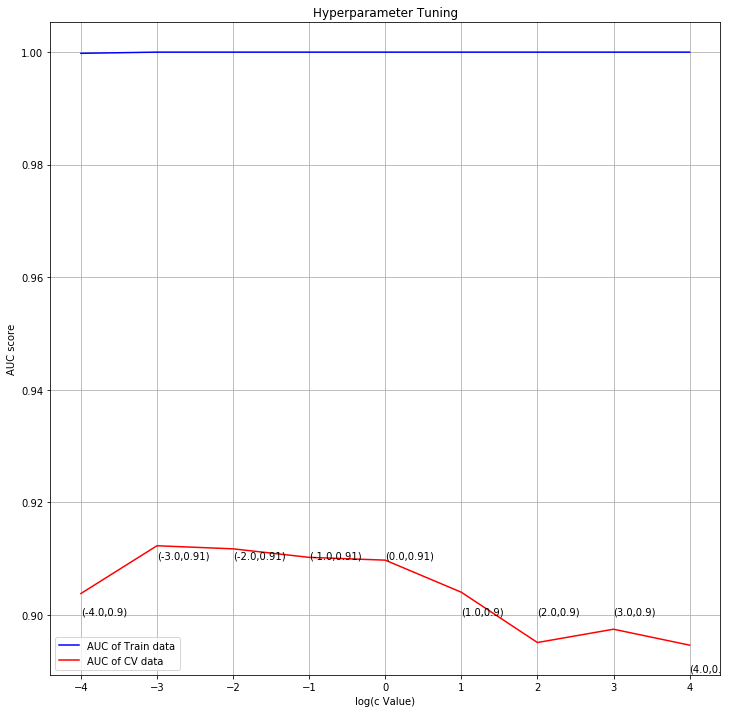

In [61]:
# auc_score plotting

auc_score(c_value=log_c,auc_train=auc_train_bow,auc_cv=auc_cv_bow)

##### Observation:

* To avoid overfitting and underfitting,choose c=0.0001, we get auc_score=0.90

In [62]:
# Apply best hyperparameter

train_proba_bow,test_proba_bow,fpr_train_bow,tpr_train_bow,fpr_test_bow,tpr_test_bow,auc_train_bow,auc_test_bow,\
class_return_bow,fi_bow=best_LR(penalty="l2",best_c=0.0001,train_vector=bow_train_vec1_std,train_label=y_train,\
                               test_vector=bow_test_vec1_std,test_label=y_test)

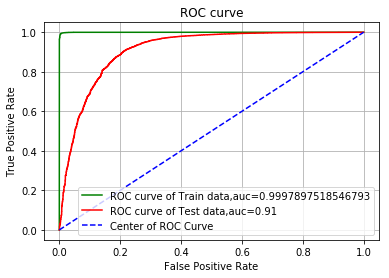

In [63]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train_bow,tpr_train=tpr_train_bow,fpr_test=fpr_test_bow,tpr_test=tpr_test_bow,\
         text1=str(auc_train_bow),text2=str(round(auc_test_bow,2)))

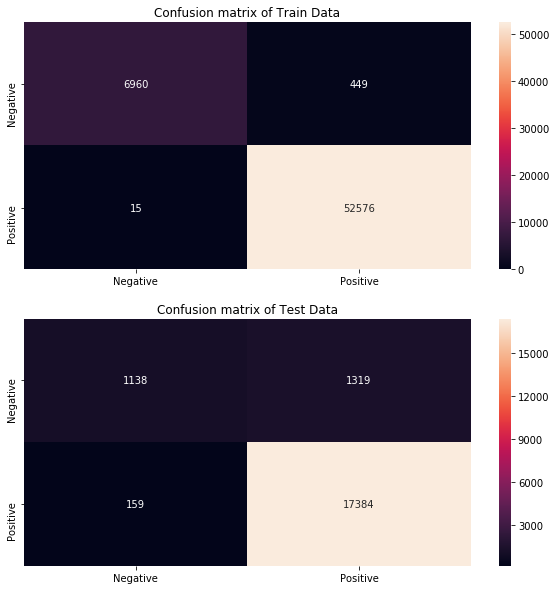

In [64]:
# confusion matrix

cm_plot(train_proba=train_proba_bow,train_label=y_train,test_proba=test_proba_bow,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (C=0.0001) on model, we get auc score of future unseen data is 0.91

#### 6.2.2 LR using TFIDF

In [65]:
# Data standardization

tfidf_train_vec1_std=data_std.fit_transform(tfidf_train_vec1)
tfidf_cv_vec1_std=data_std.transform(tfidf_cv_vec1)
tfidf_test_vec1_std=data_std.transform(tfidf_test_vec1)

In [66]:
# Hyperparameter tuning

auc_train_tfidf,auc_cv_tfidf=logistic_regression(penalty="l2",c=c,train_vector=tfidf_train_vec1_std,train_label=y_train, \
                                             cv_vector=tfidf_cv_vec1_std,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:41<00:00,  5.29s/it]


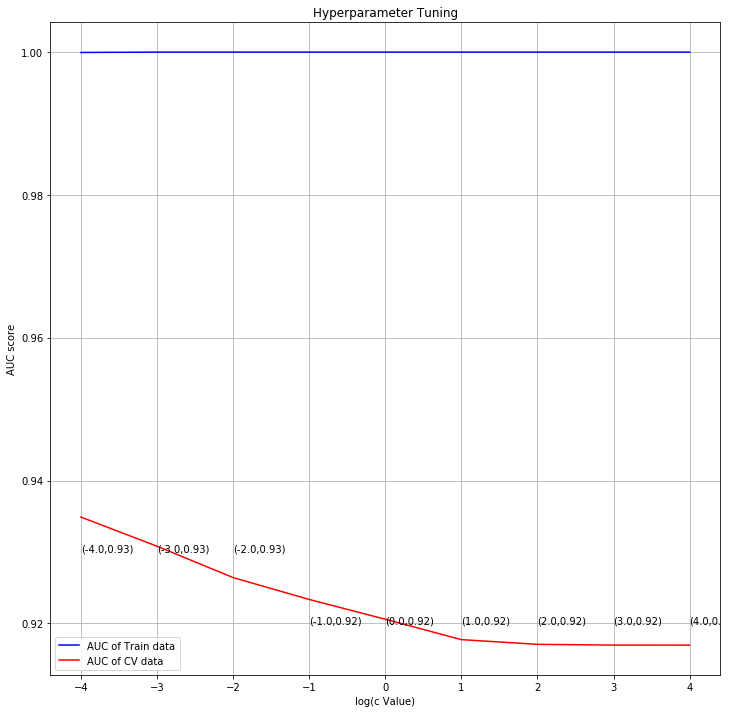

In [67]:
# auc_score plotting

auc_score(c_value=log_c,auc_train=auc_train_tfidf,auc_cv=auc_cv_tfidf)

##### Observation:

* To avoid overfitting and underfitting,choose c=0.0001, we get auc_score=0.93

In [70]:
# Apply best hyperparameter

train_proba_tfidf,test_proba_tfidf,fpr_train_tfidf,tpr_train_tfidf,fpr_test_tfidf,tpr_test_tfidf,auc_train_tfidf,auc_test_tfidf,\
class_return_tfidf,fi_tfidf=best_LR(penalty="l2",best_c=0.0001,train_vector=tfidf_train_vec1_std,train_label=y_train,\
                               test_vector=tfidf_test_vec1_std,test_label=y_test)

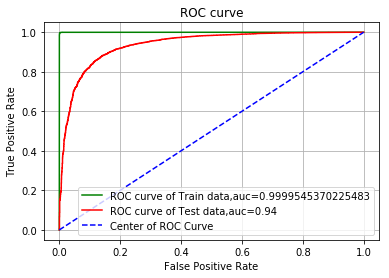

In [71]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train_tfidf,tpr_train=tpr_train_tfidf,fpr_test=fpr_test_tfidf,tpr_test=tpr_test_tfidf,\
         text1=str(auc_train_tfidf),text2=str(round(auc_test_tfidf,2)))

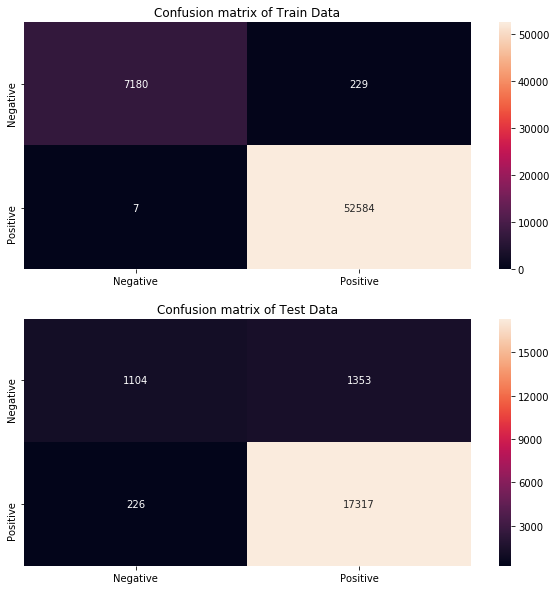

In [72]:
# confusion matrix

cm_plot(train_proba=train_proba_tfidf,train_label=y_train,test_proba=test_proba_tfidf,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (C=0.0001) on model, we get auc score of future unseen data is 0.94

#### 6.2.3 LR using Avg W2V

In [54]:
# Data standardization
data_std=StandardScaler(with_mean=True)
avg_w2v_train_vec1_std=data_std.fit_transform(avg_w2v_train)
avg_w2v_cv_vec1_std=data_std.transform(avg_w2v_cv)
avg_w2v_test_vec1_std=data_std.transform(avg_w2v_test)

In [55]:
# Hyperparameter tuning

auc_train_avg_w2v,auc_cv_avg_w2v=logistic_regression(penalty="l2",c=c,train_vector=avg_w2v_train_vec1_std,train_label=y_train, \
                                             cv_vector=avg_w2v_cv_vec1_std,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.65s/it]


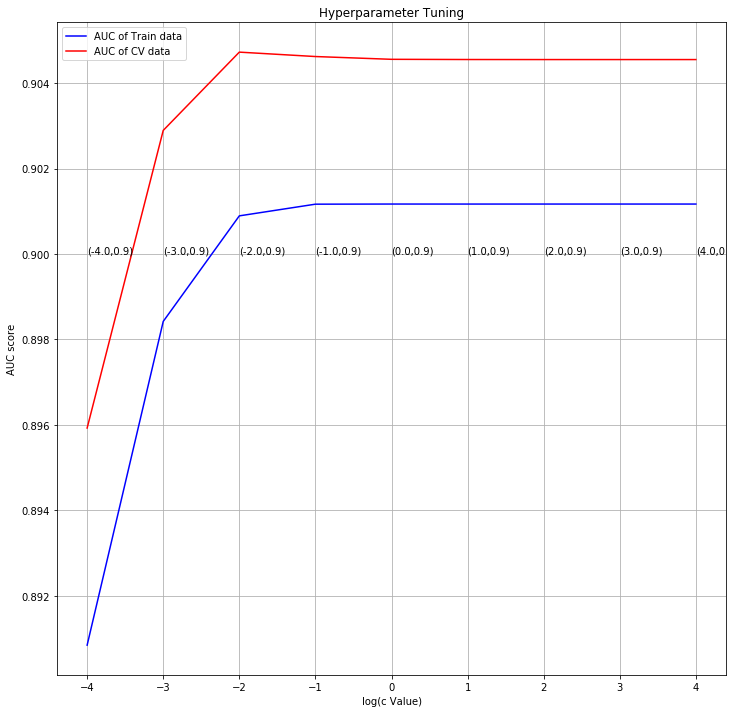

In [56]:
# auc_score plotting

auc_score(c_value=log_c,auc_train=auc_train_avg_w2v,auc_cv=auc_cv_avg_w2v)

##### Observation:

* To avoid overfitting and underfitting,choose c=0.01, we get auc_score=0.90

In [57]:
# Apply best hyperparameter

train_proba_avg_w2v,test_proba_avg_w2v,fpr_train_avg_w2v,tpr_train_avg_w2v,fpr_test_avg_w2v,tpr_test_avg_w2v,auc_train_avg_w2v,auc_test_avg_w2v,\
class_return_avg_w2v,fi_avg_w2v=best_LR(penalty="l2",best_c=0.01,train_vector=avg_w2v_train_vec1_std,train_label=y_train,\
                               test_vector=avg_w2v_test_vec1_std,test_label=y_test)

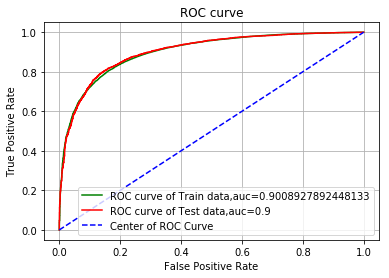

In [58]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train_avg_w2v,tpr_train=tpr_train_avg_w2v,fpr_test=fpr_test_avg_w2v,tpr_test=tpr_test_avg_w2v,\
         text1=str((auc_train_avg_w2v)),text2=str(round(auc_test_avg_w2v,2)))

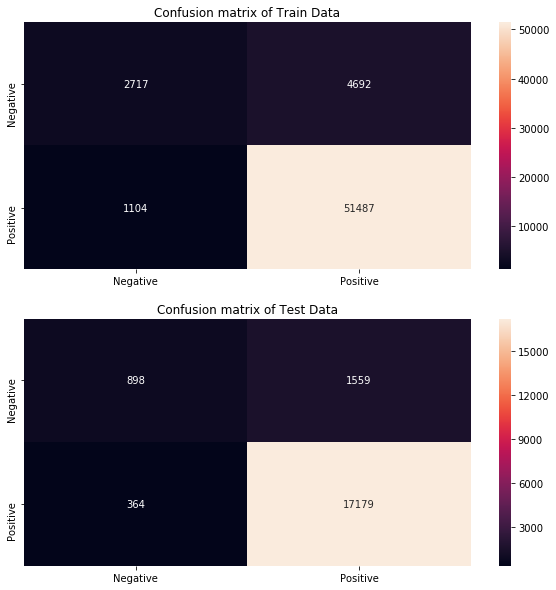

In [59]:
# confusion matrix

cm_plot(train_proba=train_proba_avg_w2v,train_label=y_train,test_proba=test_proba_avg_w2v,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (C=0.01) on model, we get auc score of future unseen data is 0.90

#### 6.2.4 LR using TFIDF-W2V

In [60]:
# Data standardization
data_std=StandardScaler(with_mean=True)
tfidf_w2v_train_vec1_std=data_std.fit_transform(tfidf_w2v_train)
tfidf_w2v_cv_vec1_std=data_std.transform(tfidf_w2v_cv)
tfidf_w2v_test_vec1_std=data_std.transform(tfidf_w2v_test)

In [61]:
# Hyperparameter tuning

auc_train_tfidf_w2v,auc_cv_tfidf_w2v=logistic_regression(penalty="l2",c=c,train_vector=tfidf_w2v_train_vec1_std,train_label=y_train, \
                                             cv_vector=tfidf_w2v_cv_vec1_std,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.83s/it]


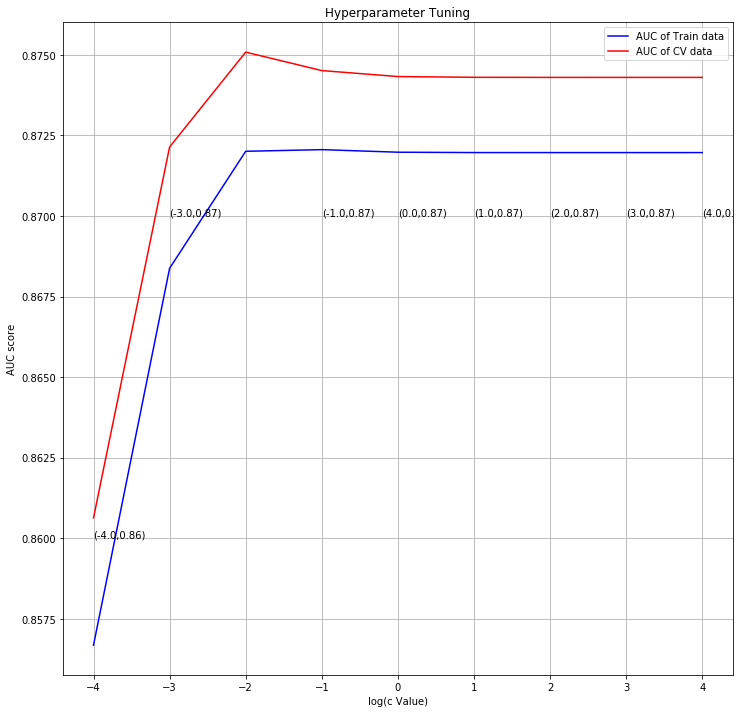

In [62]:
# auc_score plotting

auc_score(c_value=log_c,auc_train=auc_train_tfidf_w2v,auc_cv=auc_cv_tfidf_w2v)

##### Observation:

* To avoid overfitting and underfitting,choose c=0.1, we get auc_score=0.87

In [65]:
# Apply best hyperparameter

train_proba_tfidf_w2v,test_proba_tfidf_w2v,fpr_train_tfidf_w2v,tpr_train_tfidf_w2v,fpr_test_tfidf_w2v,tpr_test_tfidf_w2v,auc_train_tfidf_w2v,auc_test_tfidf_w2v,\
class_return_tfidf_w2v,fi_tfidf_w2v=best_LR(penalty="l2",best_c=0.1,train_vector=tfidf_w2v_train_vec1_std,train_label=y_train,\
                               test_vector=tfidf_w2v_test_vec1_std,test_label=y_test)

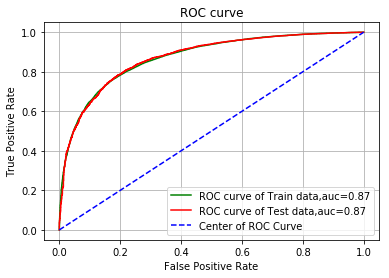

In [64]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train_tfidf_w2v,tpr_train=tpr_train_tfidf_w2v,fpr_test=fpr_test_tfidf_w2v,tpr_test=tpr_test_tfidf_w2v,\
         text1=str(round(auc_train_tfidf_w2v,2)),text2=str(round(auc_test_tfidf_w2v,2)))

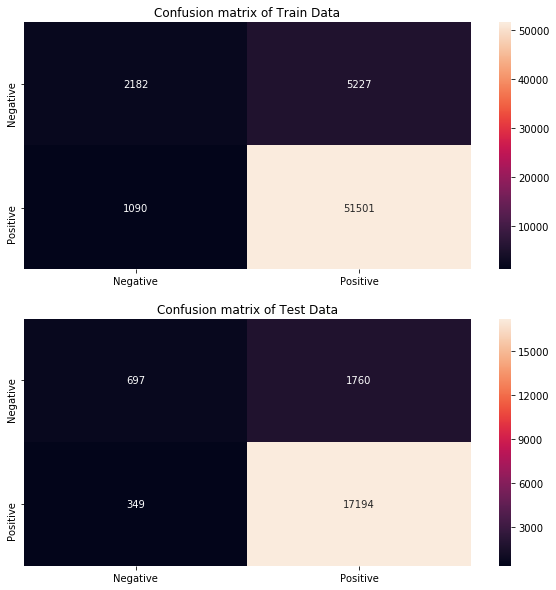

In [66]:
# confusion matrix

cm_plot(train_proba=train_proba_tfidf_w2v,train_label=y_train,test_proba=test_proba_tfidf_w2v,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (C=0.1) on model, we get auc score of future unseen data is 0.87

#### 6.3 LR using L1 Regularization

#### 6.3.1 LR using BOW

In [187]:
# Data standardization
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

In [188]:
data_std=StandardScaler(with_mean=False)
bow_train_vec1_std=data_std.fit_transform(bow_train_vec1)
bow_cv_vec1_std=data_std.transform(bow_cv_vec1)
bow_test_vec1_std=data_std.transform(bow_test_vec1)

In [189]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

In [190]:
# Hyperparameter tuning

auc_train_bow,auc_cv_bow=logistic_regression(penalty="l1",c=c,train_vector=bow_train_vec1_std,train_label=y_train, \
                                             cv_vector=bow_cv_vec1_std,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.69s/it]


In [191]:
log_c=[]
for i in c:
    log_c.append(math.log10(i))
log_c

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]

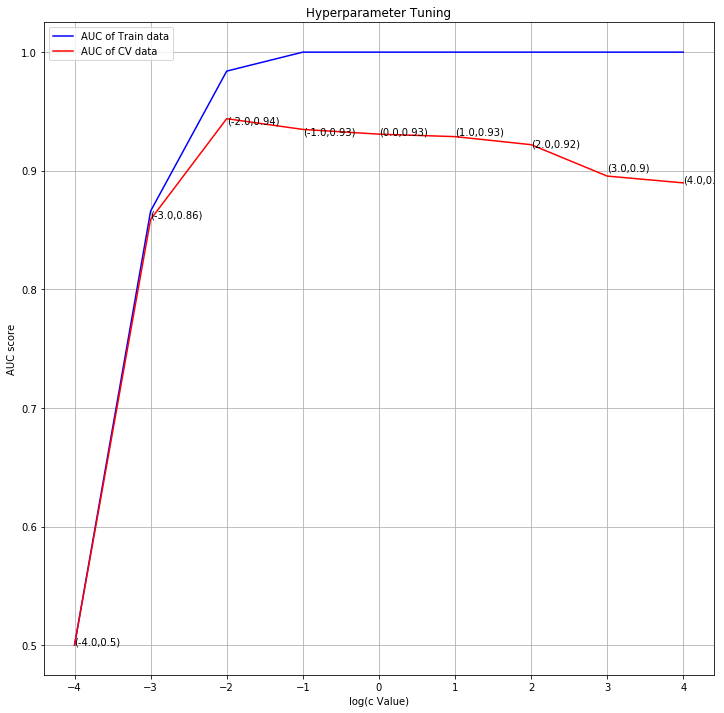

In [192]:
# auc_score plotting

auc_score(c_value=log_c,auc_train=auc_train_bow,auc_cv=auc_cv_bow)

##### Observation:

* To avoid overfitting and underfitting,choose c=0.01, we get auc_score=0.94

In [193]:
# Apply best hyperparameter

train_proba_bow,test_proba_bow,fpr_train_bow,tpr_train_bow,fpr_test_bow,tpr_test_bow,auc_train_bow,auc_test_bow,\
class_return_bow,fi_bow=best_LR(penalty="l1",best_c=0.01,train_vector=bow_train_vec1_std,train_label=y_train,\
                               test_vector=bow_test_vec1_std,test_label=y_test)

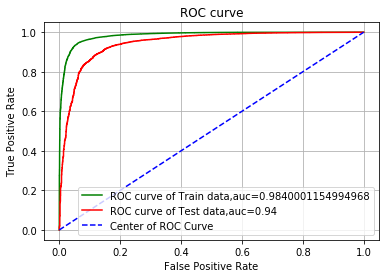

In [194]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train_bow,tpr_train=tpr_train_bow,fpr_test=fpr_test_bow,tpr_test=tpr_test_bow,\
         text1=str(auc_train_bow),text2=str(round(auc_test_bow,2)))

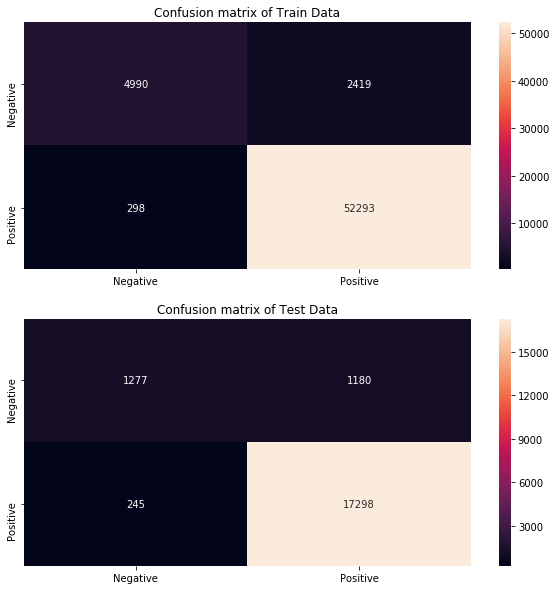

In [195]:
# confusion matrix

cm_plot(train_proba=train_proba_bow,train_label=y_train,test_proba=test_proba_bow,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (C=0.01) on model, we get auc score of future unseen data is 0.94

#### 6.3.2 LR using TFIDF

In [196]:
# Data standardization

tfidf_train_vec1_std=data_std.fit_transform(tfidf_train_vec1)
tfidf_cv_vec1_std=data_std.transform(tfidf_cv_vec1)
tfidf_test_vec1_std=data_std.transform(tfidf_test_vec1)

In [197]:
# Hyperparameter tuning

auc_train_tfidf,auc_cv_tfidf=logistic_regression(penalty="l1",c=c,train_vector=tfidf_train_vec1_std,train_label=y_train, \
                                             cv_vector=tfidf_cv_vec1_std,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.65s/it]


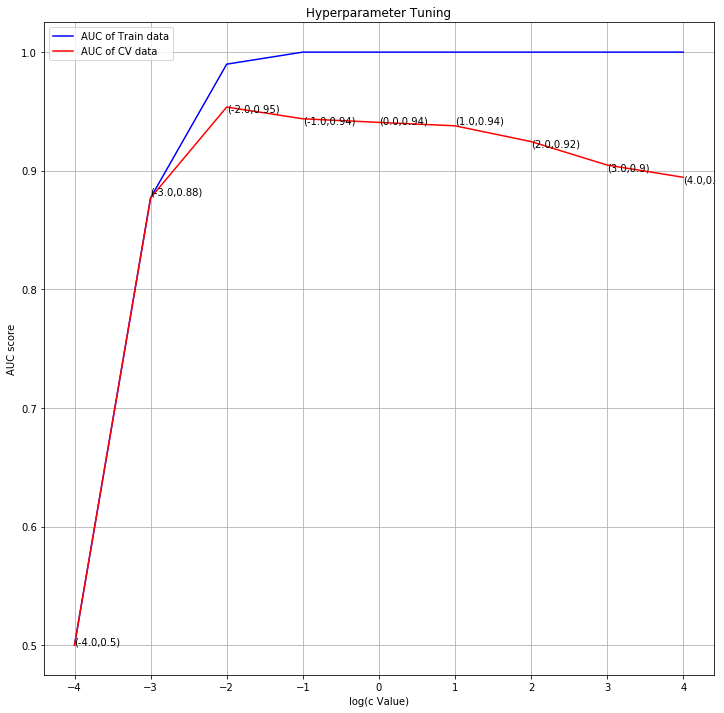

In [198]:
# auc_score plotting

auc_score(c_value=log_c,auc_train=auc_train_tfidf,auc_cv=auc_cv_tfidf)

##### Observation:

* To avoid overfitting and underfitting,choose c=0.01, we get auc_score=0.95

In [199]:
# Apply best hyperparameter

train_proba_tfidf,test_proba_tfidf,fpr_train_tfidf,tpr_train_tfidf,fpr_test_tfidf,tpr_test_tfidf,auc_train_tfidf,auc_test_tfidf,\
class_return_tfidf,fi_tfidf=best_LR(penalty="l1",best_c=0.01,train_vector=tfidf_train_vec1_std,train_label=y_train,\
                               test_vector=tfidf_test_vec1_std,test_label=y_test)

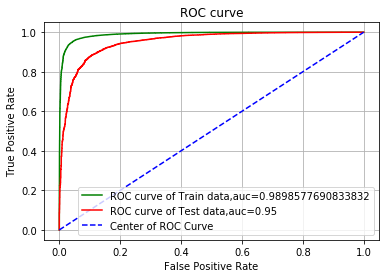

In [200]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train_tfidf,tpr_train=tpr_train_tfidf,fpr_test=fpr_test_tfidf,tpr_test=tpr_test_tfidf,\
         text1=str(auc_train_tfidf),text2=str(round(auc_test_tfidf,2)))

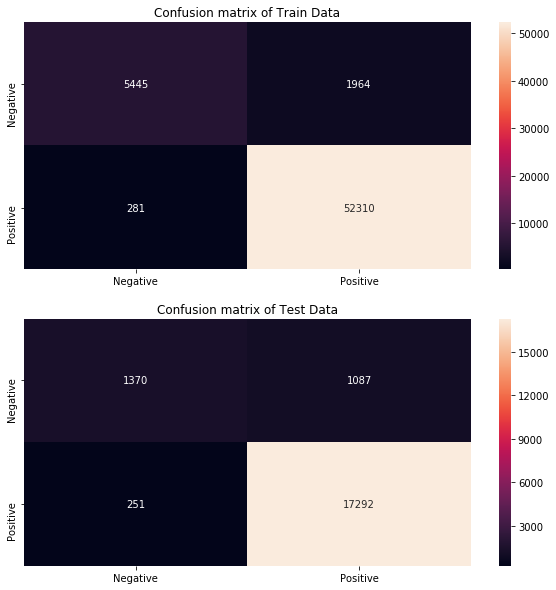

In [201]:
# confusion matrix

cm_plot(train_proba=train_proba_tfidf,train_label=y_train,test_proba=test_proba_tfidf,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (C=0.01) on model, we get auc score of future unseen data is 0.95

#### 6.3.3 LR using Avg W2V

In [203]:
# Data standardization
data_std=StandardScaler(with_mean=True)
avg_w2v_train_vec1_std=data_std.fit_transform(avg_w2v_train)
avg_w2v_cv_vec1_std=data_std.transform(avg_w2v_cv)
avg_w2v_test_vec1_std=data_std.transform(avg_w2v_test)

In [204]:
# Hyperparameter tuning

auc_train_avg_w2v,auc_cv_avg_w2v=logistic_regression(penalty="l1",c=c,train_vector=avg_w2v_train_vec1_std,train_label=y_train, \
                                             cv_vector=avg_w2v_cv_vec1_std,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:23<00:00,  3.42s/it]


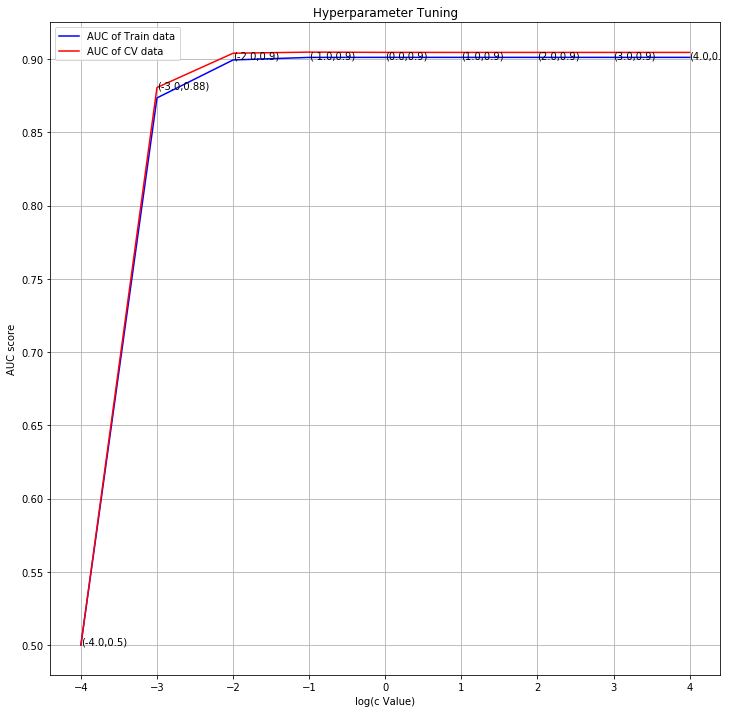

In [205]:
# auc_score plotting

auc_score(c_value=log_c,auc_train=auc_train_avg_w2v,auc_cv=auc_cv_avg_w2v)

##### Observation:

* To avoid overfitting and underfitting,choose c=0.01, we get auc_score=0.90

In [206]:
# Apply best hyperparameter

train_proba_avg_w2v,test_proba_avg_w2v,fpr_train_avg_w2v,tpr_train_avg_w2v,fpr_test_avg_w2v,tpr_test_avg_w2v,auc_train_avg_w2v,auc_test_avg_w2v,\
class_return_avg_w2v,fi_avg_w2v=best_LR(penalty="l1",best_c=0.01,train_vector=avg_w2v_train_vec1_std,train_label=y_train,\
                               test_vector=avg_w2v_test_vec1_std,test_label=y_test)

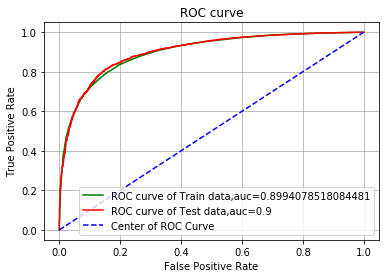

In [207]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train_avg_w2v,tpr_train=tpr_train_avg_w2v,fpr_test=fpr_test_avg_w2v,tpr_test=tpr_test_avg_w2v,\
         text1=str((auc_train_avg_w2v)),text2=str(round(auc_test_avg_w2v,2)))

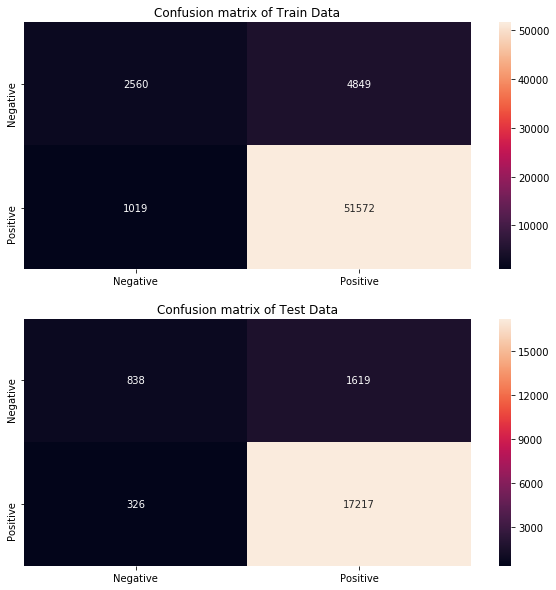

In [208]:
# confusion matrix

cm_plot(train_proba=train_proba_avg_w2v,train_label=y_train,test_proba=test_proba_avg_w2v,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (C=0.01) on model, we get auc score of future unseen data is 0.90

#### 6.3.4 LR using TFIDF-W2V

In [209]:
# Data standardization
data_std=StandardScaler(with_mean=True)
tfidf_w2v_train_vec1_std=data_std.fit_transform(tfidf_w2v_train)
tfidf_w2v_cv_vec1_std=data_std.transform(tfidf_w2v_cv)
tfidf_w2v_test_vec1_std=data_std.transform(tfidf_w2v_test)

In [210]:
# Hyperparameter tuning

auc_train_tfidf_w2v,auc_cv_tfidf_w2v=logistic_regression(penalty="l1",c=c,train_vector=tfidf_w2v_train_vec1_std,train_label=y_train, \
                                             cv_vector=tfidf_w2v_cv_vec1_std,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:19<00:00,  2.66s/it]


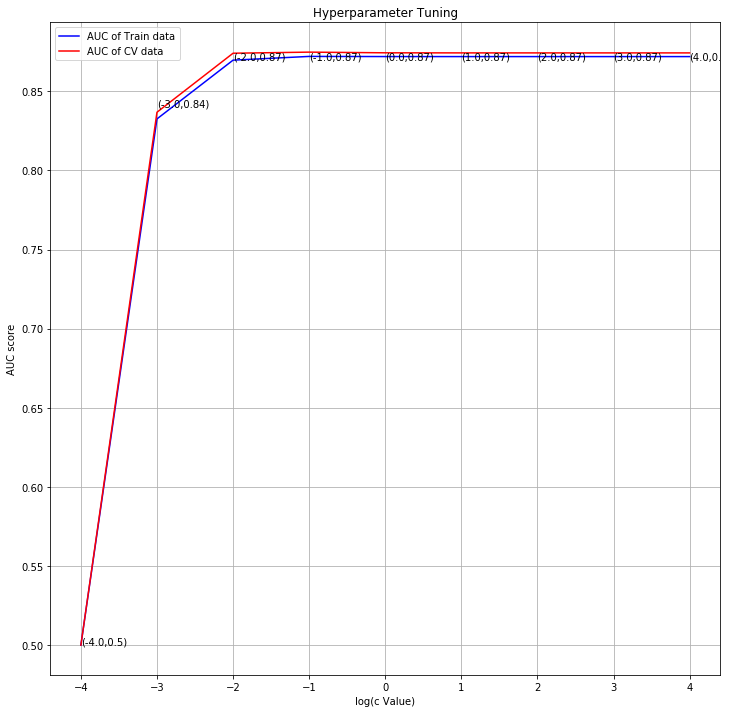

In [211]:
# auc_score plotting

auc_score(c_value=log_c,auc_train=auc_train_tfidf_w2v,auc_cv=auc_cv_tfidf_w2v)

##### Observation:

* To avoid overfitting and underfitting,choose c=0.01, we get auc_score=0.87

In [216]:
# Apply best hyperparameter

train_proba_tfidf_w2v,test_proba_tfidf_w2v,fpr_train_tfidf_w2v,tpr_train_tfidf_w2v,fpr_test_tfidf_w2v,tpr_test_tfidf_w2v,auc_train_tfidf_w2v,auc_test_tfidf_w2v,\
class_return_tfidf_w2v,fi_tfidf_w2v=best_LR(penalty="l1",best_c=0.01,train_vector=tfidf_w2v_train_vec1_std,train_label=y_train,\
                               test_vector=tfidf_w2v_test_vec1_std,test_label=y_test)

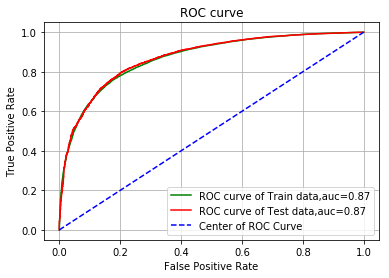

In [217]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train_tfidf_w2v,tpr_train=tpr_train_tfidf_w2v,fpr_test=fpr_test_tfidf_w2v,tpr_test=tpr_test_tfidf_w2v,\
         text1=str(round(auc_train_tfidf_w2v,2)),text2=str(round(auc_test_tfidf_w2v,2)))

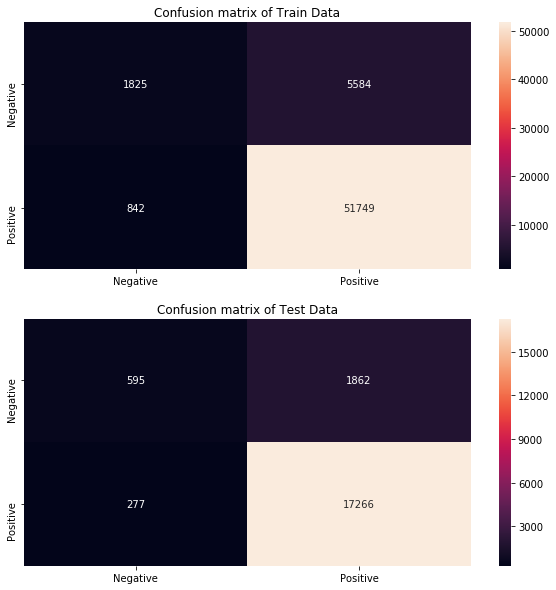

In [218]:
# confusion matrix

cm_plot(train_proba=train_proba_tfidf_w2v,train_label=y_train,test_proba=test_proba_tfidf_w2v,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (C=0.01) on model, we get auc score of future unseen data is 0.87

#### 6.4 Model Observations

In [169]:
# References
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

In [173]:
x = PrettyTable()

x.field_names = ["Vectorizer","Regularization", "Model", "Hyperparameter", "AUC"]

x.add_row(["BOW","l2","Logistic Regression",0.0001,0.91])
x.add_row(["TFIDF","l2","Logistic Regression",0.0001,0.94])
x.add_row(["Avg W2V","l2","Logistic Regression",0.01,0.90])
x.add_row(["TFIDF W2V","l2","Logistic Regression",0.1,0.87])

x.add_row(["BOW","l1","Logistic Regression",0.01,0.94])
x.add_row(["TFIDF","l1","Logistic Regression",0.01,0.95])
x.add_row(["Avg W2V","l1","Logistic Regression",0.01,0.90])
x.add_row(["TFIDF W2V","l1","Logistic Regression",0.01,0.87])
print(x)

+------------+----------------+---------------------+----------------+------+
| Vectorizer | Regularization |        Model        | Hyperparameter | AUC  |
+------------+----------------+---------------------+----------------+------+
|    BOW     |       l2       | Logistic Regression |     0.0001     | 0.91 |
|   TFIDF    |       l2       | Logistic Regression |     0.0001     | 0.94 |
|  Avg W2V   |       l2       | Logistic Regression |      0.01      | 0.9  |
| TFIDF W2V  |       l2       | Logistic Regression |      0.1       | 0.87 |
|    BOW     |       l1       | Logistic Regression |      0.01      | 0.94 |
|   TFIDF    |       l1       | Logistic Regression |      0.01      | 0.95 |
|  Avg W2V   |       l1       | Logistic Regression |      0.01      | 0.9  |
| TFIDF W2V  |       l1       | Logistic Regression |      0.01      | 0.87 |
+------------+----------------+---------------------+----------------+------+


* Logistic Regression model using L1 regularization gives better result compare to L2 regularization.
* TFIDF vectorizer gives better result compared to other vectorizers.

### 7. Feature Importance ( Pertubation Test)

* Feature importance on TFIDF and BOW 

#### 7.1 Pertubation test on TFIDF

* The pertubation test is used to find the multi col-linearity of the features.

In [76]:
# References
# To find the indices of the non zero elements in sparse matrix
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.find.html
# To generate the the random noise using Normal Distribution
# https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.normal.html
# https://github.com/cyanamous/

import scipy as ss

###### Before adding noise weight  vector (w)

In [77]:
# before adding noise

LR_model=LogisticRegression(penalty='l2',C=0.0001)
LR_model.fit(tfidf_train_vec1_std,y_train)
w=LR_model.coef_

In [78]:
w

array([[ 0.00050878,  0.00232268, -0.00046573, ...,  0.001298  ,
         0.00187846,  0.00200268]])

###### After adding noise weight vector (w1)

In [79]:
# adding noise (epsilon)

tfidf_new=tfidf_train_vec1_std

# finding the indices of the non zero elements in sparse matrix

row,column,value=ss.sparse.find(tfidf_new)

In [80]:
value.shape

(2982287,)

In [81]:
# generate noise using normal distribution

size_noise=value.size
noise=np.random.normal(loc=0,scale=0.01,size=size_noise)

In [82]:
# adding noise

tfidf_new[row,column]=tfidf_new[row,column]+ noise

###### Finding w' using LR model

In [84]:
LR_model=LogisticRegression(penalty='l2',C=0.0001)
LR_model.fit(tfidf_new,y_train)
w1=LR_model.coef_

###### Find the number of non-zero elements in weight vector (w and w1)

In [85]:
print("non zero elements in w")
print("="*125)
print(np.count_nonzero(w))
print(" ")
print("non zero elements in w1")
print("="*125)
print(np.count_nonzero(w1))

non zero elements in w
79401
 
non zero elements in w1
79401


###### Add a small noise (10^6) in weight vectors (w &w1) to avoid division by error

In [86]:
x=w+0.000001
y=w1+0.000001

###### % change of weight vectors

$\ delta=(| (x-y)/x |) * 100 $

In [87]:
x[0,7000:7010]

array([ 0.00014327,  0.00337085, -0.00022766, -0.00019283,  0.00212652,
        0.00054103, -0.00365521,  0.00266228, -0.0027219 ,  0.00072837])

In [88]:
y[0,7000:7010]

array([ 0.00014128,  0.00337253, -0.00022683, -0.00019223,  0.00212633,
        0.00054117, -0.00365436,  0.00266233, -0.00272029,  0.0007289 ])

In [89]:
delta= abs((x-y)/x)*100

In [90]:
delta

array([[0.15710869, 0.02246449, 0.36535909, ..., 0.0173163 , 0.00734251,
        0.0222908 ]])

In [91]:
# sort delta as a ascending order
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.sort.html

delta1=delta[0]
delta_new=np.sort(delta1)

In [92]:
delta_new.shape

(79401,)

In [93]:
delta_new

array([1.28409340e-06, 1.44873695e-06, 2.17251166e-06, ...,
       3.16691493e+02, 4.16160044e+02, 7.65556486e+02])

###### Compute percentile

In [94]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html
# Print array values from scientific notation to numerical value 
# https://stackoverflow.com/questions/32635911/convert-elements-of-an-array-from-scientific-notation-to-decimal-notation-in-pyt

np.set_printoptions(formatter={'float_kind':'{:f}'.format})
percen_list=[10,20,30,40,50,60,70,80,90,100]

In [95]:
percen_value=np.percentile(delta_new,percen_list)

In [96]:
percen_value

array([0.005257, 0.010783, 0.016766, 0.023592, 0.031790, 0.042472,
       0.058073, 0.085540, 0.170575, 765.556486])

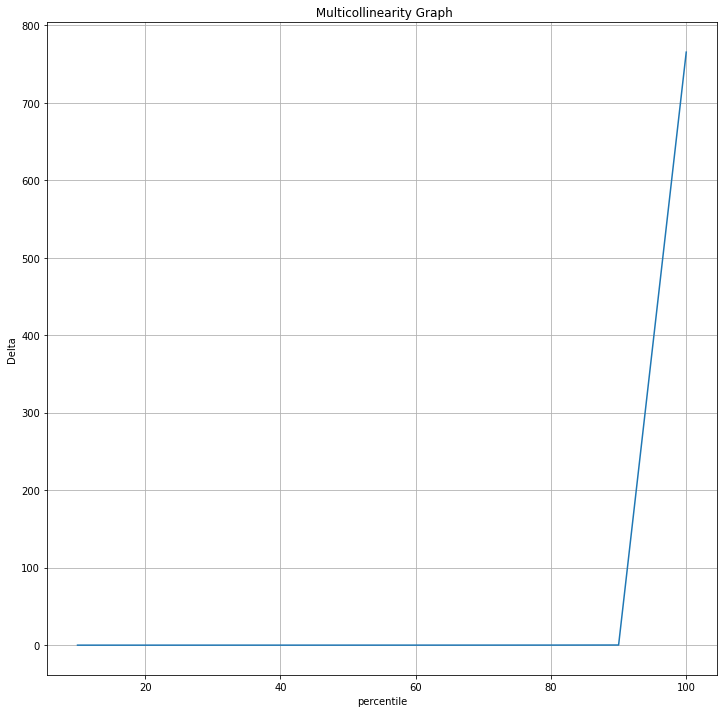

In [97]:
plt.close
plt.figure(figsize=(12,12))
plt.plot(percen_list,percen_value)
plt.grid()
plt.title(" Multicollinearity Graph")
plt.xlabel("percentile")
plt.ylabel("Delta")
plt.show()

###### Observation:

* There is 99 to 100 suddenly values are increased.

In [98]:
# percentile between 99 to 100

percen_list1=[98.9,99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]

In [99]:
percen_value1=np.percentile(delta_new,percen_list1)

In [100]:
percen_value1

array([1.596408, 1.777940, 2.003597, 2.230807, 2.474988, 2.887005,
       3.578471, 4.426083, 6.429230, 9.441628, 19.841869, 765.556486])

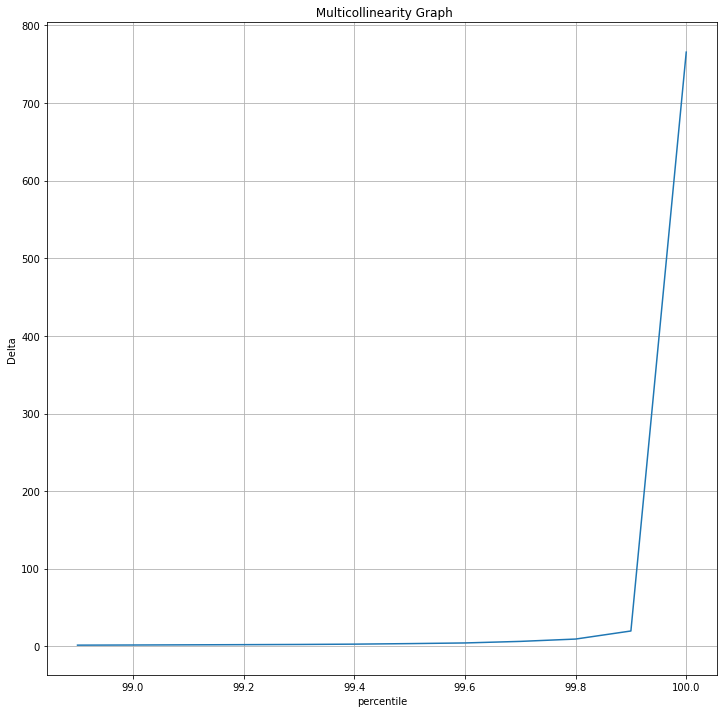

In [101]:
plt.close
plt.figure(figsize=(12,12))
plt.plot(percen_list1,percen_value1)
plt.grid()
plt.title(" Multicollinearity Graph")
plt.xlabel("percentile")
plt.ylabel("Delta")
plt.show()

##### Observation:

* After the 19.84 the value suddenly increases to 765. So there is threshold in x axis is 99.9, the corresponded y axis value is 19.84. So we need to find how many features are above the threshold percentage change. These features are have multicollinear property.

###### Removing Multicollinearity Features

In [104]:
# References
# https://stackoverflow.com/questions/7270321/finding-the-index-of-elements-based-on-a-condition-using-python-list-comprehensi

fi_thres=delta1[np.where(delta1 >= 19.84)].size

In [105]:
fi_thres

80

* Here we have 80 features are above the threshold, that means 80 features are have Multicollinear property.

In [106]:
fi_thres1=np.where(delta1 >= 19.84)

In [107]:

fi_thres1[0].shape

(80,)

In [108]:
# Feature Importance Selection

w_fi=np.argsort(w[0])[::-1]

In [109]:
w_fi.shape

(79401,)

In [110]:
p_class=w_fi[0:20]
n_class=w_fi[-21:-1]

In [111]:
# checking whether the multicollinear feature present are not in top 10 features.

for i in p_class:
    for j in fi_thres1[0]:
        if i == j:
            print(j)

In [112]:
for i in n_class:
    for j in fi_thres1[0]:
        if i == j:
            print(j)

###### 7.1.1 Feature names whose  percentage change is above the threshold  (Multicollinearty Features in TFIDF)

In [115]:
print(np.take(tfidf_model.get_feature_names(),fi_thres1[0]))

['ad someth' 'alley' 'altern pasta' 'amazon web' 'ate half' 'bad not'
 'bag alway' 'bag better' 'bag one' 'bit oliv' 'boast' 'bottl order'
 'bought read' 'box groceri' 'cat recent' 'caus like' 'cheaper could'
 'cinnamon coffe' 'cinnamon good' 'clark' 'coffe receiv' 'cold ice'
 'common use' 'dental clean' 'drink sweet' 'eat kid' 'erin' 'even home'
 'experi excel' 'fill top' 'find elsewher' 'find final' 'funk'
 'german candi' 'golean bar' 'high calor' 'individu tea' 'live hawaii'
 'long dog' 'love vegan' 'mix daughter' 'much got' 'not everyday'
 'not mine' 'not prevent' 'not splinter' 'one machin' 'one pick'
 'one tablespoon' 'overfil' 'perfect substitut' 'place make' 'pound stuff'
 'pretti nice' 'probe' 'problem digest' 'product four' 'product morn'
 'product wife' 'realli expens' 'regular water' 'savvi' 'sell case'
 'sign automat' 'slap' 'small size' 'strawberri watermelon' 'sugar order'
 'sweeten soda' 'tast earthi' 'though know' 'treat famili' 'trick make'
 'use alon' 'use must' 'wat

###### 7.1.2 Top 20 features in Positive and Negative Class (TFIDF)

In [113]:
print("Top 20 Positive Features")
print("="*125)
print(np.take(tfidf_model.get_feature_names(),p_class))
print(" ")
print("Top 20 Negative Features")
print("="*125)
print(np.take(tfidf_model.get_feature_names(),n_class))

Top 20 Positive Features
['great' 'love' 'best' 'good' 'delici' 'excel' 'favorit' 'perfect' 'use'
 'find' 'wonder' 'nice' 'tasti' 'make' 'easi' 'high recommend' 'enjoy'
 'thank' 'recommend' 'high']
 
Top 20 Negative Features
['not tast' 'unfortun' 'wors' 'wast' 'stale' 'bland' 'return' 'two star'
 'aw' 'not good' 'wast money' 'would not' 'not purchas' 'threw' 'terribl'
 'horribl' 'not recommend' 'not worth' 'worst' 'not buy']


#### 7.2 Pertubation test on BOW

* The pertubation test is used to find the multi col-linearity of the features.

In [116]:
# References
# To find the indices of the non zero elements in sparse matrix
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.find.html
# To generate the the random noise using Normal Distribution
# https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.normal.html
# https://github.com/cyanamous/

import scipy as ss

###### Before adding noise weight  vector (w)

In [122]:
# before adding noise

LR_model=LogisticRegression(penalty='l2',C=0.0001)
LR_model.fit(bow_train_vec1_std,y_train)
w=LR_model.coef_

In [123]:
w

array([[0.001019, 0.003088, -0.001515, ..., 0.001082, 0.000709, 0.000958]])

###### After adding noise weight vector (w1)

In [124]:
# adding noise (epsilon)

bow_new=bow_train_vec1_std

# finding the indices of the non zero elements in sparse matrix

row,column,value=ss.sparse.find(bow_new)

In [125]:
value.shape

(2982287,)

In [126]:
# generate noise using normal distribution

size_noise=value.size
noise=np.random.normal(loc=0,scale=0.01,size=size_noise)

In [127]:
# adding noise

bow_new[row,column]=bow_new[row,column]+ noise

###### Finding w' using LR model

In [128]:
LR_model=LogisticRegression(penalty='l2',C=0.0001)
LR_model.fit(bow_new,y_train)
w1=LR_model.coef_

###### Find the number of non-zero elements in weight vector (w and w1)

In [129]:
print("non zero elements in w")
print("="*125)
print(np.count_nonzero(w))
print(" ")
print("non zero elements in w1")
print("="*125)
print(np.count_nonzero(w1))

non zero elements in w
79401
 
non zero elements in w1
79401


###### Add a small noise (10^6) in weight vectors (w &w1) to avoid division by error

In [130]:
x=w+0.000001
y=w1+0.000001

###### % change of weight vectors

$\ delta=(| (x-y)/x |) * 100 $

In [131]:
x[0,7000:7010]

array([0.000136, 0.003476, -0.000423, -0.000897, 0.002441, 0.000362,
       -0.003277, 0.001905, -0.002832, 0.000133])

In [132]:
y[0,7000:7010]

array([0.000135, 0.003476, -0.000422, -0.000897, 0.002442, 0.000363,
       -0.003277, 0.001906, -0.002832, 0.000132])

In [133]:
delta= abs((x-y)/x)*100

In [134]:
delta

array([[0.141973, 0.060021, 0.099562, ..., 0.015487, 0.164000, 0.000384]])

In [135]:
# sort delta as a ascending order
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.sort.html

delta1=delta[0]
delta_new=np.sort(delta1)

In [136]:
delta_new.shape

(79401,)

In [137]:
delta_new

array([0.000000, 0.000000, 0.000001, ..., 272.682140, 343.648370,
       693.561895])

###### Compute percentile

In [138]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html
# Print array values from scientific notation to numerical value 
# https://stackoverflow.com/questions/32635911/convert-elements-of-an-array-from-scientific-notation-to-decimal-notation-in-pyt

np.set_printoptions(formatter={'float_kind':'{:f}'.format})
percen_list=[10,20,30,40,50,60,70,80,90,100]

In [139]:
percen_value=np.percentile(delta_new,percen_list)

In [140]:
percen_value

array([0.005686, 0.011623, 0.018192, 0.025553, 0.034420, 0.045526,
       0.062098, 0.092435, 0.183587, 693.561895])

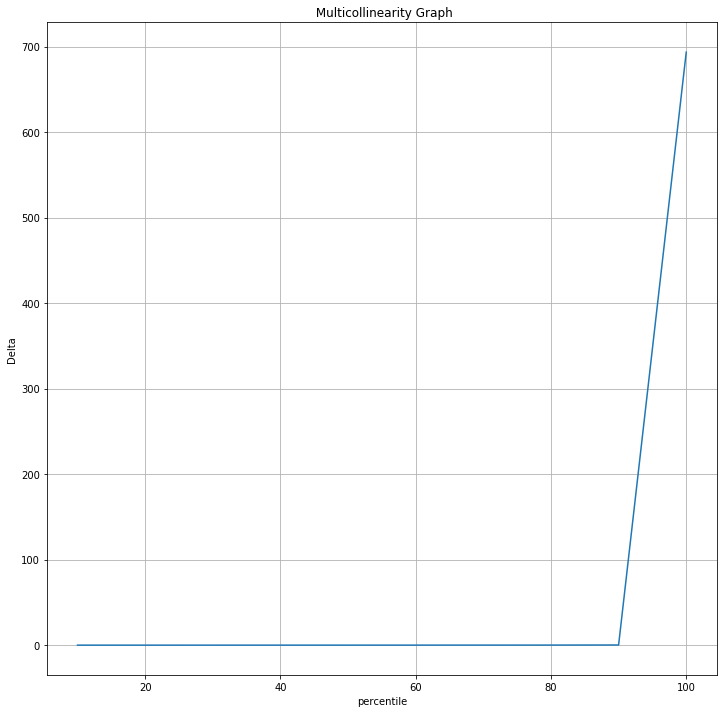

In [141]:
plt.close
plt.figure(figsize=(12,12))
plt.plot(percen_list,percen_value)
plt.grid()
plt.title(" Multicollinearity Graph")
plt.xlabel("percentile")
plt.ylabel("Delta")
plt.show()

###### Observation:

* There is 99 to 100 suddenly values are increased.

In [142]:
# percentile between 99 to 100

percen_list1=[98.9,99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]

In [143]:
percen_value1=np.percentile(delta_new,percen_list1)

In [144]:
percen_value1

array([1.574329, 1.724038, 1.901539, 2.118729, 2.404870, 2.830813,
       3.365141, 4.176536, 5.765983, 8.756203, 20.974039, 693.561895])

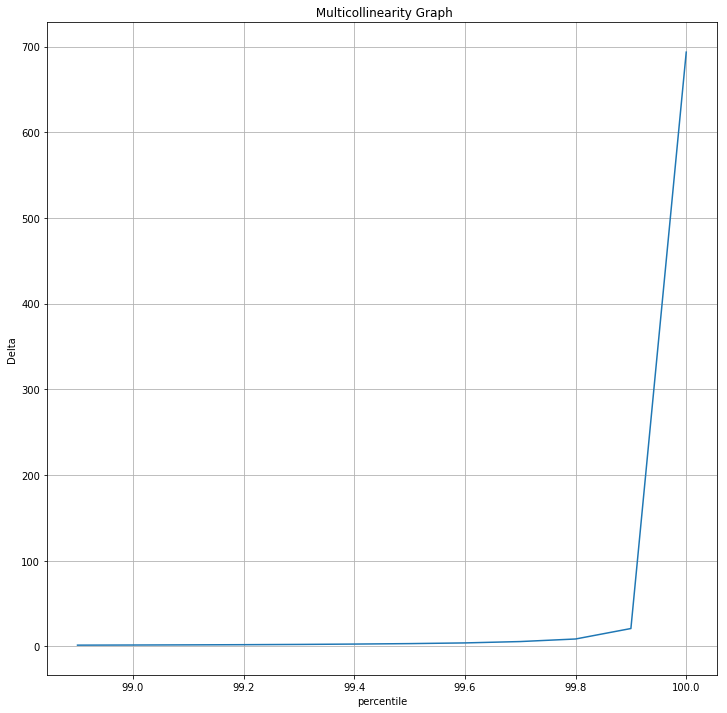

In [145]:
plt.close
plt.figure(figsize=(12,12))
plt.plot(percen_list1,percen_value1)
plt.grid()
plt.title(" Multicollinearity Graph")
plt.xlabel("percentile")
plt.ylabel("Delta")
plt.show()

##### Observation:

* After the 20.97 the value suddenly increases to 693. So there is threshold in x axis is 99.9, the corresponded y axis value is 20.97. So we need to find how many features are above the threshold percentage change. These features are have multicollinear property.

###### Removing Multicollinearity Features

In [146]:
# References
# https://stackoverflow.com/questions/7270321/finding-the-index-of-elements-based-on-a-condition-using-python-list-comprehensi

fi_thres=delta1[np.where(delta1 >= 20.97)].size

In [147]:
fi_thres

80

* Here we have 80 features are above the threshold, that means 80 features are have Multicollinear property.

In [148]:
fi_thres1=np.where(delta1 >= 20.97)

In [149]:

fi_thres1[0].shape

(80,)

In [150]:
# Feature Importance Selection

w_fi=np.argsort(w[0])[::-1]

In [151]:
w_fi.shape

(79401,)

In [152]:
p_class=w_fi[0:20]
n_class=w_fi[-21:-1]

In [153]:
# checking whether the multicollinear feature present are not in top 10 features.

for i in p_class:
    for j in fi_thres1[0]:
        if i == j:
            print(j)

In [154]:
for i in n_class:
    for j in fi_thres1[0]:
        if i == j:
            print(j)

###### 7.2.1 Feature names whose  percentage change is above the threshold  (Multicollinearty Features in BOW)

In [157]:
print(np.take(bow_model.get_feature_names(),fi_thres1[0]))

['absorb bodi' 'amazon web' 'anoth sweeten' 'away could' 'bonsai'
 'box six' 'calori sugar' 'candi tree' 'chemic not' 'chew almost'
 'chocol actual' 'coffe either' 'corni' 'diet plan' 'diseas give'
 'earth tea' 'everyth would' 'favorit chicken' 'first chip'
 'flavor instead' 'flavor pretti' 'food actual' 'food problem'
 'found thank' 'fountain' 'get sent' 'got home' 'great crisp' 'great go'
 'grinder not' 'guarante analysi' 'half gallon' 'honey sugar' 'keep offic'
 'kind weird' 'land lake' 'light roast' 'littl graini' 'long find'
 'lot great' 'ludicr' 'mani would' 'mart' 'miss good' 'ml' 'move around'
 'need steep' 'nescaf dolc' 'new bag' 'not cure' 'not daili' 'nut rice'
 'open open' 'pay oz' 'probabl not' 'product supplier' 'purchas love'
 'see would' 'sharp edg' 'shop buy' 'shredder' 'size bit' 'small amount'
 'small easi' 'smell sweet' 'snack may' 'sound appeal' 'starbuck bean'
 'stay long' 'stuffer christma' 'sugar say' 'think corn' 'time due'
 'tri experi' 'two thing' 'use packag

###### 7.2.2 Top 20 features in Positive and Negative Class (BOW)

In [158]:
print("Top 20 Positive Features")
print("="*125)
print(np.take(bow_model.get_feature_names(),p_class))
print(" ")
print("Top 20 Negative Features")
print("="*125)
print(np.take(bow_model.get_feature_names(),n_class))

Top 20 Positive Features
['great' 'love' 'best' 'good' 'delici' 'excel' 'favorit' 'perfect'
 'wonder' 'tasti' 'high recommend' 'nice' 'find' 'easi' 'tast great'
 'great product' 'thank' 'enjoy' 'use' 'great tast']
 
Top 20 Negative Features
['wast' 'money' 'stale' 'bland' 'not order' 'unfortun' 'return' 'two star'
 'not good' 'would not' 'aw' 'terribl' 'not purchas' 'threw' 'wast money'
 'horribl' 'not recommend' 'worst' 'not worth' 'not buy']


### 8. Sparsity of weight vector

* Sparsity on TFIDF and BOW

#### 8.1 Sparsity using TFIDF

In [132]:
# Using L1 regularization to create sparsity
# References:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [130]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

In [131]:
log_c=[]
for i in c:
    log_c.append(math.log10(i))
log_c

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]

In [134]:
non_zero_sparsity=[]
for i in tqdm(c):
    
    # model fitting
    
    model=LogisticRegression(penalty="l1",C=i)
    model.fit(tfidf_train_vec1_std,y_train)
    
    weight=model.coef_
    non_zero_elements=np.count_nonzero(weight[0])
    non_zero_sparsity.append(non_zero_elements)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.68s/it]


In [135]:
# plotting Sparsity values

In [136]:
non_zero_sparsity

[0, 62, 4032, 10614, 13322, 19862, 42654, 66477, 78364]

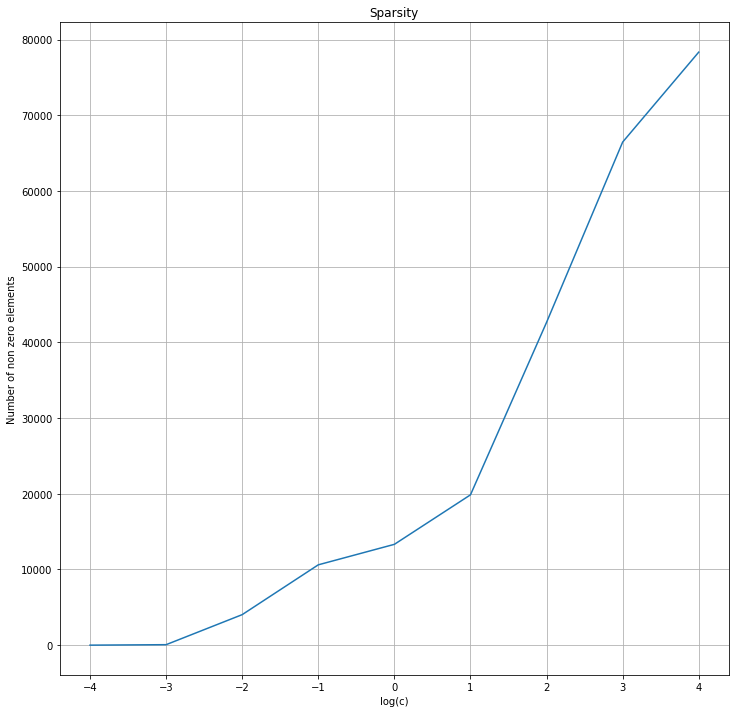

In [137]:
plt.close()
plt.figure(figsize=(12,12))
plt.plot(log_c,non_zero_sparsity)
plt.grid()
plt.title("Sparsity")
plt.xlabel("log(c)")
plt.ylabel("Number of non zero elements")
plt.show()

##### Observation

* When lambda increases,the sparsity (Less number of non zero elements) of the model weight vector also increases or number of non zero elements of the weight vector are less. Here C=(1/ lambda), so when c decreases the sparsity of the model weight vector becomes increases.

In [138]:
p=PrettyTable()
p.field_names = ["C", "Number of Non Zero elements"]

p.add_row([0.0001,0])
p.add_row([0.001,62])
p.add_row([0.01,4032])
p.add_row([0.1,10614])
p.add_row([1,13322])
p.add_row([10,19862])
p.add_row([100,42654])
p.add_row([1000,66477])
p.add_row([10000,78364])
print(p)

+--------+-----------------------------+
|   C    | Number of Non Zero elements |
+--------+-----------------------------+
| 0.0001 |              0              |
| 0.001  |              62             |
|  0.01  |             4032            |
|  0.1   |            10614            |
|   1    |            13322            |
|   10   |            19862            |
|  100   |            42654            |
|  1000  |            66477            |
| 10000  |            78364            |
+--------+-----------------------------+


#### 8.1 Sparsity using BOW

In [159]:
# Using L1 regularization to create sparsity
# References:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [160]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

In [161]:
log_c=[]
for i in c:
    log_c.append(math.log10(i))
log_c

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]

In [162]:
non_zero_sparsity=[]
for i in tqdm(c):
    
    # model fitting
    
    model=LogisticRegression(penalty="l1",C=i)
    model.fit(bow_train_vec1_std,y_train)
    
    weight=model.coef_
    non_zero_elements=np.count_nonzero(weight[0])
    non_zero_sparsity.append(non_zero_elements)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.59s/it]


In [163]:
# plotting Sparsity values

In [164]:
non_zero_sparsity

[0, 55, 3354, 10081, 12584, 18677, 26394, 71894, 78871]

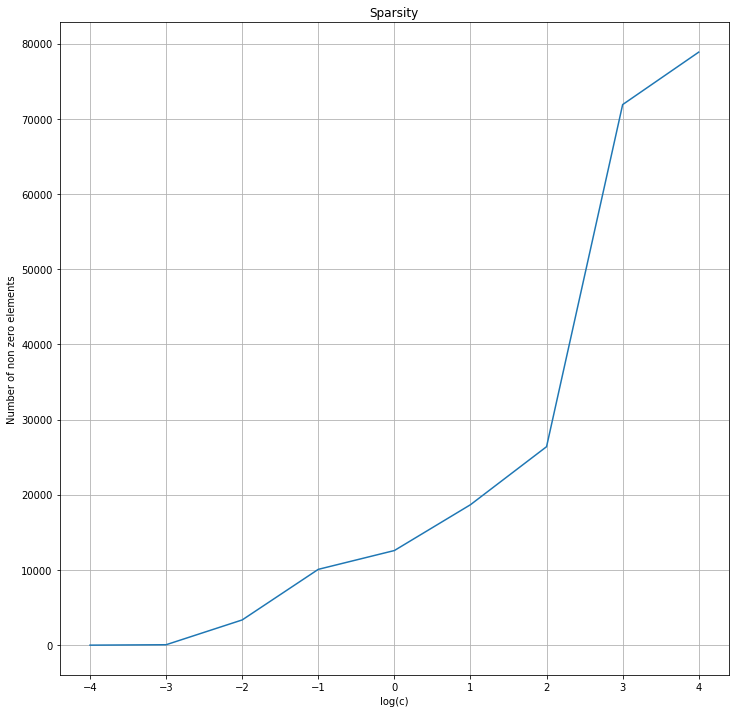

In [165]:
plt.close()
plt.figure(figsize=(12,12))
plt.plot(log_c,non_zero_sparsity)
plt.grid()
plt.title("Sparsity")
plt.xlabel("log(c)")
plt.ylabel("Number of non zero elements")
plt.show()

##### Observation

* When lambda increases,the sparsity (Less number of non zero elements) of the model weight vector also increases or number of non zero elements of the weight vector are less. Here C=(1/ lambda), so when c decreases the sparsity of the model weight vector becomes increases.

In [166]:
o=PrettyTable()
o.field_names = ["C", "Number of Non Zero elements"]

o.add_row([0.0001,0])
o.add_row([0.001,55])
o.add_row([0.01,3354])
o.add_row([0.1,10081])     
o.add_row([1,12584])
o.add_row([10,18677])
o.add_row([100,26394])
o.add_row([1000,71894])
o.add_row([10000,78871])
print(o)

+--------+-----------------------------+
|   C    | Number of Non Zero elements |
+--------+-----------------------------+
| 0.0001 |              0              |
| 0.001  |              55             |
|  0.01  |             3354            |
|  0.1   |            10081            |
|   1    |            12584            |
|   10   |            18677            |
|  100   |            26394            |
|  1000  |            71894            |
| 10000  |            78871            |
+--------+-----------------------------+


### 9. Feature Engineering

* We do feature engineering on LR using TFIDF-W2V. Because this gives less performance result compared to others.

#### 9.1 Adding Summary Text as a Feature with Review Text

* We consider summary text as a feature,we do preprocessing and featurization on the summary text and then we horizontally stack the summary text to the review text. so finally we get the extra word vector to improve our model.

##### 9.1.1 Summary Text Preprocessing

In [139]:
raw_summary_text_data=filter_data.Summary.values

In [140]:
# Preprocessing 

preprocessed_summary_text_data=[]
for i in tqdm(raw_summary_text_data):
# removing of HTML tags
    a=re.sub("<.*?>"," ",i)
# removing url
    b=re.sub(r"http\S+"," ",a)
# expanding contractions
    c=decontracted(b)
# removing alphA_numeric
    d=re.sub("\S*\d\S*", " ",c)
# removing Special characters
    e=re.sub('[^A-Za-z0-9]+', ' ',d)
# removing stopwords
    k=[]
    for w in e.split():
        if w.lower() not in stopwords:
            s=(stemmer.stem(w.lower())).encode('utf8')
            k.append(s)
    preprocessed_summary_text_data.append(b' '.join(k).decode())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [00:56<00:00, 6478.60it/s]


In [141]:
filter_data["Summary"]=preprocessed_summary_text_data

In [142]:
filter_data.shape

(364171, 10)

In [143]:
# we took the sample data size as 150k 

final_data=filter_data[:100000]
final_data.shape

(100000, 10)

##### 9.1.2. Data Splitting

In [144]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split

In [145]:
X=final_data.Summary
Y=final_data.Score

In [146]:
x_1,x_test1,y_1,y_test1=train_test_split(X,Y,test_size=0.2,random_state=40)
x_train1,x_cv1,y_train1,y_cv1=train_test_split(x_1,y_1,test_size=0.25,random_state=40)
print(" Train data Size")
print(x_train1.shape,y_train.shape)

print("cv data size")
print(x_cv1.shape,y_cv.shape)
print("Test data size")
print(x_test1.shape,y_test.shape)

 Train data Size
(60000,) (60000,)
cv data size
(20000,) (20000,)
Test data size
(20000,) (20000,)


##### 9.1.3. Featurization

##### TFIDF - W2V

In [147]:
list_sentences_train1=[]
for i in tqdm(list(x_train1)):
    list_sentences_train1.append(i.split())

100%|█████████████████████████████████████████████████████████████████████████| 60000/60000 [00:01<00:00, 45780.05it/s]


In [148]:
word2vec_model_fe=Word2Vec(list_sentences_train1,min_count=5,size=50,workers=4)

In [149]:
word2vec_words_train1=list(word2vec_model_fe.wv.vocab)
print(" Number of words")
print("_________________")
print(" ")
print(len(word2vec_words_train1))
print("="*125)
print(" sample words")
print("_________________")
print(" ")
print(word2vec_words_train1[100:150])

 Number of words
_________________
 
2757
 sample words
_________________
 
['strong', 'yummmmmm', 'nectar', 'nice', 'select', 'confus', 'keurig', 'organ', 'black', 'cherri', 'concentr', 'must', 'work', 'food', 'make', 'go', 'yeah', 'move', 'rice', 'krispi', 'treat', 'barbequ', 'chip', 'green', 'bowl', 'edibl', 'pet', 'health', 'risk', 'get', 'unexpect', 'guest', 'super', 'deal', 'anyon', 'need', 'gluten', 'favorit', 'no', 'raspberri', 'celesti', 'season', 'garden', 'refresh', 'tasti', 'light', 'kiwi', 'low', 'caffein', 'hand']


In [150]:
# list of sentences cv data

list_sentences_cv1=[]
for i in tqdm(list(x_cv1)):
    list_sentences_cv1.append(i.split())

# list of sentences test data

list_sentences_test1=[]
for i in tqdm(list(x_test1)):
    list_sentences_test1.append(i.split())

100%|████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 526377.06it/s]


In [151]:
# References
# https://stackoverflow.com/questions/21553327
# https://github.com/devBOX03


# tfidf word2vec on training data

model=TfidfVectorizer()
tfidf_w2v_model=model.fit_transform(x_train1)
tfidf_w2v=model.get_feature_names()
tfidf_word2vec_train=[]
row=0
for i in tqdm(list_sentences_train1):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_fe.wv[w]
            tfidf_freq=tfidf_w2v_model[row,tfidf_w2v.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_train.append(vec)
    row=row+1
tfidf_w2v_train1=np.asmatrix(tfidf_word2vec_train)
print("Shape of TFIDF word2vec train")
print(tfidf_w2v_train1.shape)

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:48<00:00, 1244.12it/s]


Shape of TFIDF word2vec train
(60000, 50)


In [152]:
# tfidf word2vec on cv data

tfidf_w2v_model=model.transform(x_cv1)
tfidf_word2vec_cv=[]
row=0
for i in tqdm(list_sentences_cv1):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_fe.wv[w]
            tfidf_freq=tfidf_w2v_model[row,tfidf_w2v.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_cv.append(vec)
    row=row+1
tfidf_w2v_cv1=np.asmatrix(tfidf_word2vec_cv)
print("Shape of TFIDF word2vec cv")
print(tfidf_w2v_cv1.shape)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:13<00:00, 1535.89it/s]


Shape of TFIDF word2vec cv
(20000, 50)


In [153]:
# tfidf word2vec on test data

tfidf_w2v_model=model.transform(x_test1)
tfidf_word2vec_test=[]
row=0
for i in tqdm(list_sentences_test1):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_fe.wv[w]
            tfidf_freq=tfidf_w2v_model[row,tfidf_w2v.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_test.append(vec)
    row=row+1
tfidf_w2v_test1=np.asmatrix(tfidf_word2vec_test)
print("Shape of TFIDF word2vec test")
print(tfidf_w2v_test1.shape)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1555.04it/s]


Shape of TFIDF word2vec test
(20000, 50)


##### 9.1.4 Horizontally stacking

In [154]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html

In [155]:
# For training data

tfidf_w2v_train_fe=np.hstack((tfidf_w2v_train,tfidf_w2v_train1))

# For cv data

tfidf_w2v_cv_fe=np.hstack((tfidf_w2v_cv,tfidf_w2v_cv1))

# For test data

tfidf_w2v_test_fe=np.hstack((tfidf_w2v_test,tfidf_w2v_test1))

In [156]:
print(tfidf_w2v_train_fe.shape)
print(tfidf_w2v_cv_fe.shape)
print(tfidf_w2v_test_fe.shape)

(60000, 100)
(20000, 100)
(20000, 100)


##### 9.1.5 Feature Engineering on LR (TFIDF-W2V) using L2 Regularization

In [157]:
# Data standardization
data_std=StandardScaler(with_mean=True)
tfidf_w2v_train_fe_std=data_std.fit_transform(tfidf_w2v_train_fe)
tfidf_w2v_cv_fe_std=data_std.transform(tfidf_w2v_cv_fe)
tfidf_w2v_test_fe_std=data_std.transform(tfidf_w2v_test_fe)

In [158]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

In [159]:
log_c=[]
for i in c:
    log_c.append(math.log10(i))
log_c

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]

In [160]:
# To eliminate NaN values produced in the TFIDF W2V vectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
# https://stackoverflow.com/questions/44727793/imputer-mean-strategy-removes-nan-instead-of-replacing

from sklearn.impute import SimpleImputer

In [161]:
imp=SimpleImputer(missing_values=np.nan,strategy='mean')
tfidf_w2v_train_fe_im=imp.fit_transform(tfidf_w2v_train_fe_std)
tfidf_w2v_cv_fe_im=imp.fit_transform(tfidf_w2v_cv_fe_std)
tfidf_w2v_test_fe_im=imp.fit_transform(tfidf_w2v_test_fe_std)

In [162]:
# Hyperparameter tuning

auc_train_tfidf_w2v_fe,auc_cv_tfidf_w2v_fe=logistic_regression(penalty="l2",c=c,train_vector=tfidf_w2v_train_fe_im,train_label=y_train, \
                                             cv_vector=tfidf_w2v_cv_fe_im,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:15<00:00, 10.37s/it]


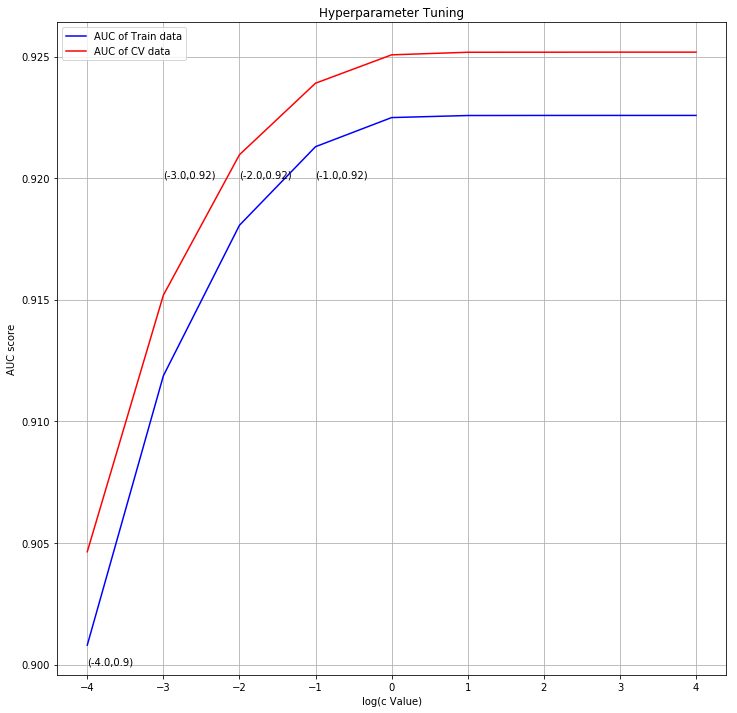

In [163]:
# auc_score plotting

auc_score(c_value=log_c,auc_train=auc_train_tfidf_w2v_fe,auc_cv=auc_cv_tfidf_w2v_fe)

##### Observation:

* To avoid overfitting and underfitting,choose c=0.1, we get auc_score=0.93

In [164]:
# Apply best hyperparameter

train_proba_tfidf_w2v,test_proba_tfidf_w2v,fpr_train_tfidf_w2v,tpr_train_tfidf_w2v,fpr_test_tfidf_w2v,tpr_test_tfidf_w2v,auc_train_tfidf_w2v,auc_test_tfidf_w2v,\
class_return_tfidf_w2v,fi_tfidf_w2v=best_LR(penalty="l2",best_c=0.1,train_vector=tfidf_w2v_train_fe_im,train_label=y_train,\
                               test_vector=tfidf_w2v_test_fe_im,test_label=y_test)

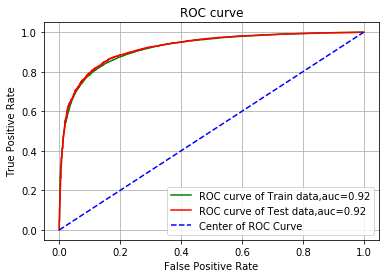

In [165]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train_tfidf_w2v,tpr_train=tpr_train_tfidf_w2v,fpr_test=fpr_test_tfidf_w2v,tpr_test=tpr_test_tfidf_w2v,\
         text1=str(round(auc_train_tfidf_w2v,2)),text2=str(round(auc_test_tfidf_w2v,2)))

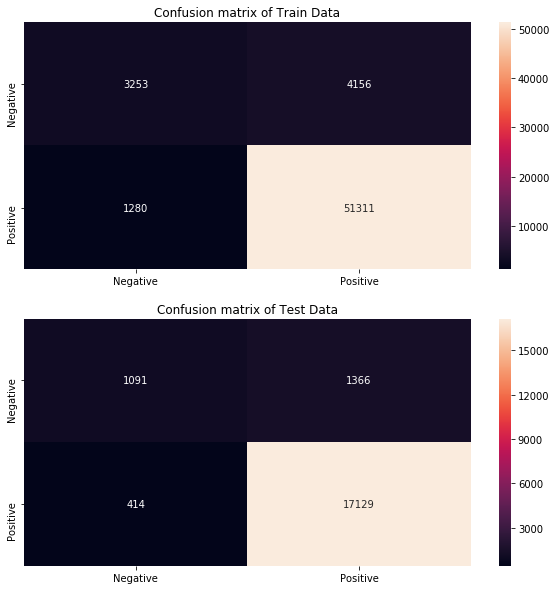

In [166]:
# confusion matrix

cm_plot(train_proba=train_proba_tfidf_w2v,train_label=y_train,test_proba=test_proba_tfidf_w2v,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (C=0.1) on model, we get auc score of future unseen data is 0.92

##### 9.1.6 Feature Engineering on LR (TFIDF-W2V) using L1 Regularization

In [228]:
# Data standardization
data_std=StandardScaler(with_mean=True)
tfidf_w2v_train_fe_std=data_std.fit_transform(tfidf_w2v_train_fe)
tfidf_w2v_cv_fe_std=data_std.transform(tfidf_w2v_cv_fe)
tfidf_w2v_test_fe_std=data_std.transform(tfidf_w2v_test_fe)

In [229]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

In [230]:
log_c=[]
for i in c:
    log_c.append(math.log10(i))
log_c

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]

In [231]:
# To eliminate NaN values produced in the TFIDF W2V vectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
# https://stackoverflow.com/questions/44727793/imputer-mean-strategy-removes-nan-instead-of-replacing

from sklearn.impute import SimpleImputer

In [232]:
imp=SimpleImputer(missing_values=np.nan,strategy='mean')
tfidf_w2v_train_fe_im=imp.fit_transform(tfidf_w2v_train_fe_std)
tfidf_w2v_cv_fe_im=imp.fit_transform(tfidf_w2v_cv_fe_std)
tfidf_w2v_test_fe_im=imp.fit_transform(tfidf_w2v_test_fe_std)

In [233]:
# Hyperparameter tuning

auc_train_tfidf_w2v_fe,auc_cv_tfidf_w2v_fe=logistic_regression(penalty="l1",c=c,train_vector=tfidf_w2v_train_fe_im,train_label=y_train, \
                                             cv_vector=tfidf_w2v_cv_fe_im,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [09:09<00:00, 92.07s/it]


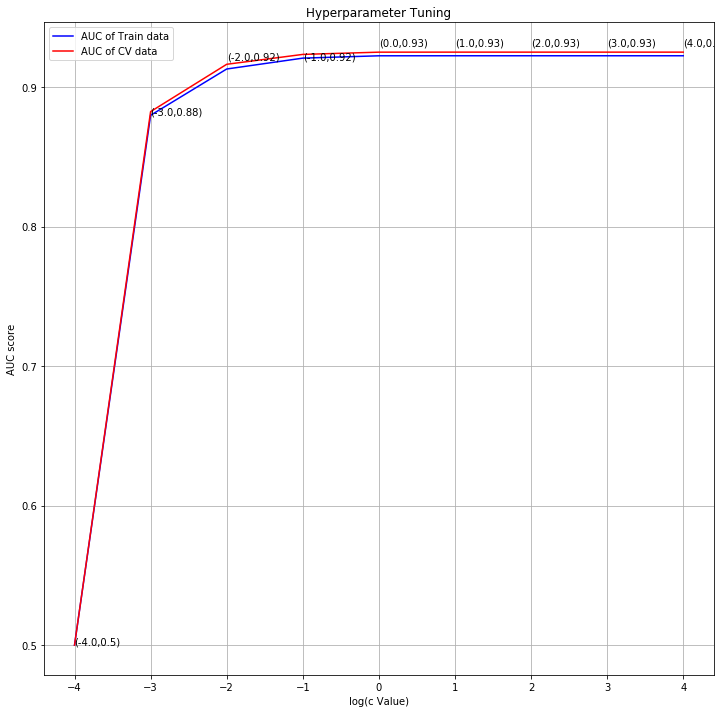

In [234]:
# auc_score plotting

auc_score(c_value=log_c,auc_train=auc_train_tfidf_w2v_fe,auc_cv=auc_cv_tfidf_w2v_fe)

##### Observation:

* To avoid overfitting and underfitting,choose c=0.01, we get auc_score=0.92

In [235]:
# Apply best hyperparameter

train_proba_tfidf_w2v,test_proba_tfidf_w2v,fpr_train_tfidf_w2v,tpr_train_tfidf_w2v,fpr_test_tfidf_w2v,tpr_test_tfidf_w2v,auc_train_tfidf_w2v,auc_test_tfidf_w2v,\
class_return_tfidf_w2v,fi_tfidf_w2v=best_LR(penalty="l1",best_c=0.01,train_vector=tfidf_w2v_train_fe_im,train_label=y_train,\
                               test_vector=tfidf_w2v_test_fe_im,test_label=y_test)

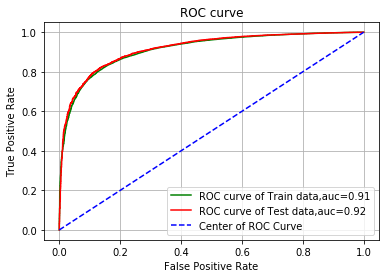

In [236]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train_tfidf_w2v,tpr_train=tpr_train_tfidf_w2v,fpr_test=fpr_test_tfidf_w2v,tpr_test=tpr_test_tfidf_w2v,\
         text1=str(round(auc_train_tfidf_w2v,2)),text2=str(round(auc_test_tfidf_w2v,2)))

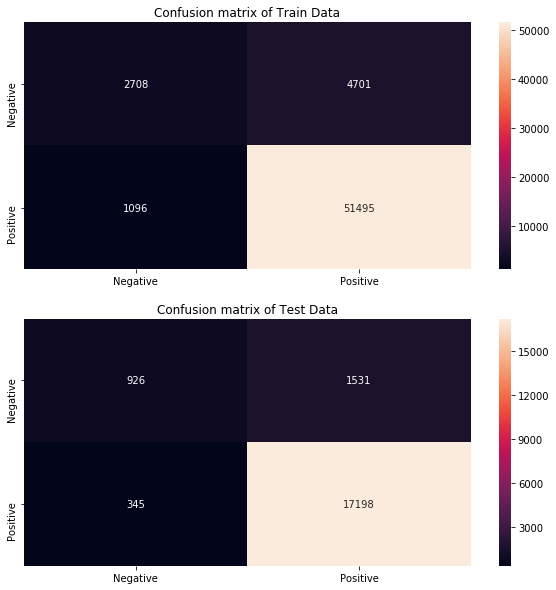

In [237]:
# confusion matrix

cm_plot(train_proba=train_proba_tfidf_w2v,train_label=y_train,test_proba=test_proba_tfidf_w2v,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (C=0.01) on model, we get auc score of future unseen data is 0.92

#### 9.2 Adding Review Text length as a feature with Review and Summary Text vector

In [168]:
# Lengh of the Words in Each Review document

a=[]
for i in preprocessed_text_data:
    a.append(len(i.split()))

In [169]:
# Adding Length as a new Feature in DataFrame

filter_data["Length"]=a

##### 9.2.1Column Standardization using Standardization Formula:

* $\ (Xi-mean)/std $

In [170]:
mean1=filter_data.Length.mean()
std1=filter_data.Length.std()

In [171]:
b=a
c=[]
for i in b:
    stand=(i-mean1)/std1
    c.append(abs(stand))

In [172]:
filter_data.Length=c

##### 9.2.2. Data Splitting

In [173]:
# we took the sample data size as 100k 

final_data=filter_data[:100000]
final_data.shape

(100000, 11)

In [174]:
X=final_data.Length
Y=final_data.Score

In [175]:
x_1,x_test2,y_1,y_test2=train_test_split(X,Y,test_size=0.2,random_state=40)
x_train2,x_cv2,y_train2,y_cv2=train_test_split(x_1,y_1,test_size=0.25,random_state=40)
print(" Train data Size")
print(x_train2.shape,y_train.shape)

print("cv data size")
print(x_cv2.shape,y_cv.shape)
print("Test data size")
print(x_test2.shape,y_test.shape)

 Train data Size
(60000,) (60000,)
cv data size
(20000,) (20000,)
Test data size
(20000,) (20000,)


##### 9.2.3 Horizontally stacking

##### Feature Engineering on TFIDF-W2V

In [176]:
# hstack takes list of list values. so we convert list to list of list

# For BOW
a_train=[]
for i in x_train2.values:
    b=[]
    b.append(i)
    a_train.append(b)
    
a_cv=[]
for i in x_cv2.values:
    b=[]
    b.append(i)
    a_cv.append(b)
    
a_test=[]
for i in x_test2.values:
    b=[]
    b.append(i)
    a_test.append(b)

In [177]:
# For Training Data
tfidf_w2v_train_fe_im1=np.hstack((tfidf_w2v_train_fe_im,a_train))


# For cv Data

tfidf_w2v_cv_fe_im1=np.hstack((tfidf_w2v_cv_fe_im,a_cv))


# For test Data

tfidf_w2v_test_fe_im1=np.hstack((tfidf_w2v_test_fe_im,a_test))

In [178]:
tfidf_w2v_train_fe_im1.shape

(60000, 101)

##### 9.2.4 Feature engineering on LR using L2 Regularization

In [179]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

In [180]:
log_c=[]
for i in c:
    log_c.append(math.log10(i))
log_c

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]

In [181]:
# Hyperparameter tuning

auc_train_tfidf_w2v_fe,auc_cv_tfidf_w2v_fe=logistic_regression(penalty="l2",c=c,train_vector=tfidf_w2v_train_fe_im1,train_label=y_train, \
                                             cv_vector=tfidf_w2v_cv_fe_im1,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:04<00:00,  8.74s/it]


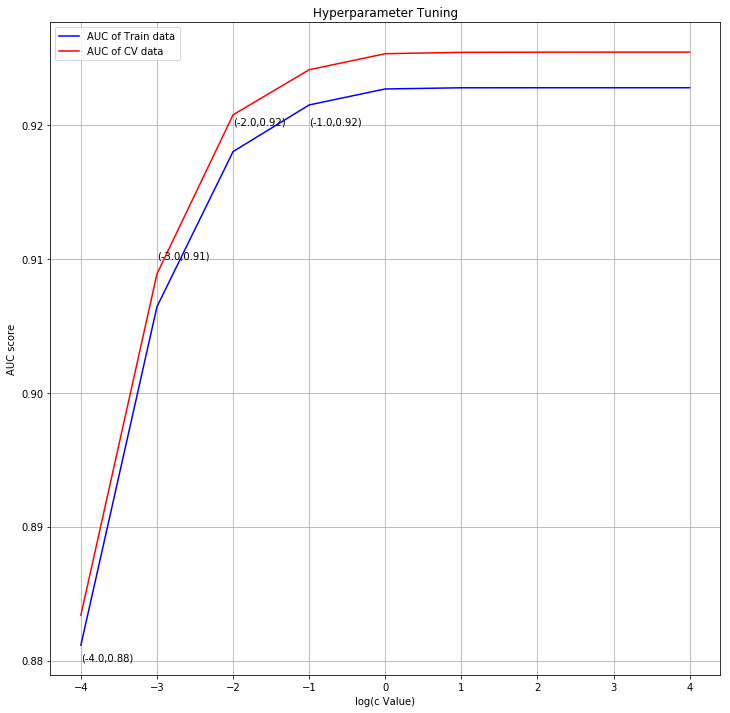

In [182]:
# auc_score plotting

auc_score(c_value=log_c,auc_train=auc_train_tfidf_w2v_fe,auc_cv=auc_cv_tfidf_w2v_fe)

##### Observation:

* To avoid overfitting and underfitting,choose c=0.1, we get auc_score=0.92

In [183]:
# Apply best hyperparameter

train_proba_tfidf_w2v,test_proba_tfidf_w2v,fpr_train_tfidf_w2v,tpr_train_tfidf_w2v,fpr_test_tfidf_w2v,tpr_test_tfidf_w2v,auc_train_tfidf_w2v,auc_test_tfidf_w2v,\
class_return_tfidf_w2v,fi_tfidf_w2v=best_LR(penalty="l2",best_c=0.1,train_vector=tfidf_w2v_train_fe_im1,train_label=y_train,\
                               test_vector=tfidf_w2v_test_fe_im1,test_label=y_test)

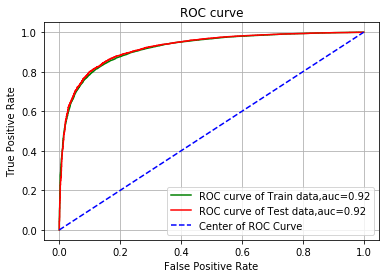

In [184]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train_tfidf_w2v,tpr_train=tpr_train_tfidf_w2v,fpr_test=fpr_test_tfidf_w2v,tpr_test=tpr_test_tfidf_w2v,\
         text1=str(round(auc_train_tfidf_w2v,2)),text2=str(round(auc_test_tfidf_w2v,2)))

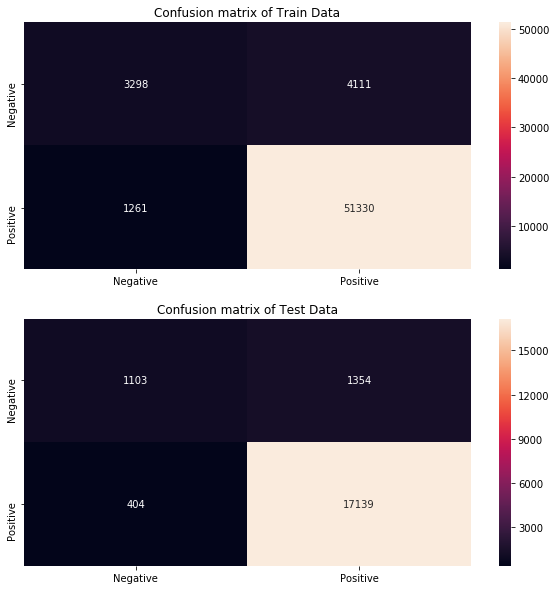

In [185]:
# confusion matrix

cm_plot(train_proba=train_proba_tfidf_w2v,train_label=y_train,test_proba=test_proba_tfidf_w2v,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (C=0.1) on model, we get auc score of future unseen data is 0.92

##### 9.2.5 Feature engineering on LR using L1 Regularization

In [238]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

In [239]:
log_c=[]
for i in c:
    log_c.append(math.log10(i))
log_c

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]

In [240]:
# Hyperparameter tuning

auc_train_tfidf_w2v_fe,auc_cv_tfidf_w2v_fe=logistic_regression(penalty="l1",c=c,train_vector=tfidf_w2v_train_fe_im1,train_label=y_train, \
                                             cv_vector=tfidf_w2v_cv_fe_im1,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [09:36<00:00, 91.13s/it]


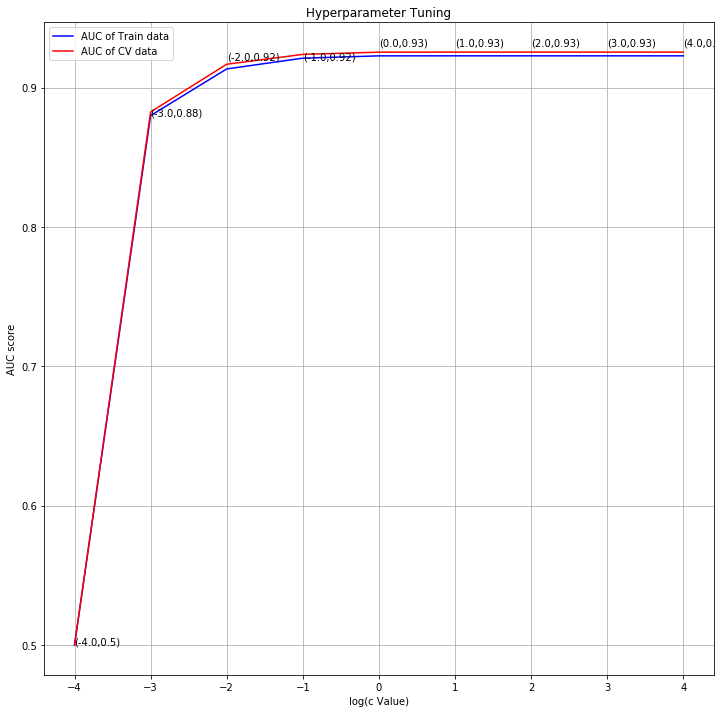

In [241]:
# auc_score plotting

auc_score(c_value=log_c,auc_train=auc_train_tfidf_w2v_fe,auc_cv=auc_cv_tfidf_w2v_fe)

##### Observation:

* To avoid overfitting and underfitting,choose c=0.01, we get auc_score=0.92

In [242]:
# Apply best hyperparameter

train_proba_tfidf_w2v,test_proba_tfidf_w2v,fpr_train_tfidf_w2v,tpr_train_tfidf_w2v,fpr_test_tfidf_w2v,tpr_test_tfidf_w2v,auc_train_tfidf_w2v,auc_test_tfidf_w2v,\
class_return_tfidf_w2v,fi_tfidf_w2v=best_LR(penalty="l1",best_c=0.01,train_vector=tfidf_w2v_train_fe_im1,train_label=y_train,\
                               test_vector=tfidf_w2v_test_fe_im1,test_label=y_test)

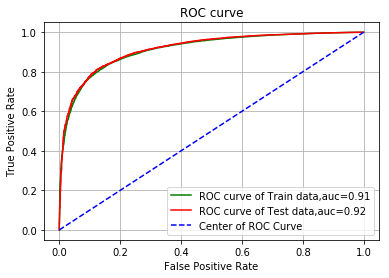

In [243]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train_tfidf_w2v,tpr_train=tpr_train_tfidf_w2v,fpr_test=fpr_test_tfidf_w2v,tpr_test=tpr_test_tfidf_w2v,\
         text1=str(round(auc_train_tfidf_w2v,2)),text2=str(round(auc_test_tfidf_w2v,2)))

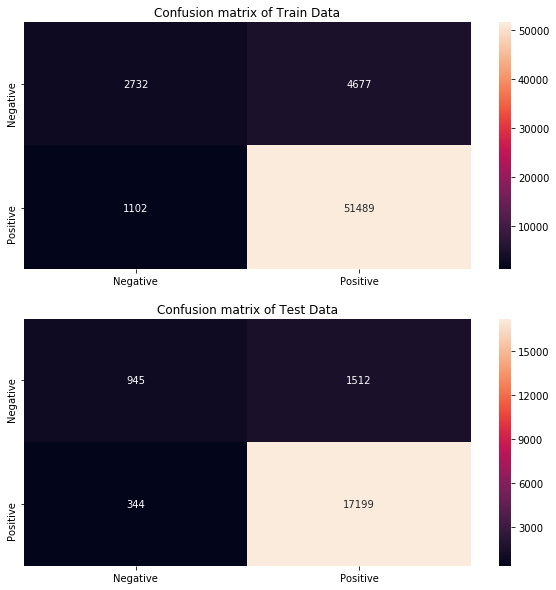

In [244]:
# confusion matrix

cm_plot(train_proba=train_proba_tfidf_w2v,train_label=y_train,test_proba=test_proba_tfidf_w2v,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (C=0.01) on model, we get auc score of future unseen data is 0.92

#### 9.3 Model Observations After Feature Engineering

In [171]:
y = PrettyTable()
z= PrettyTable()
print ("After Applying Feature Engineering on Model")
print(' ')
print("Feature Engineering( Review Text + Summary)")
print(' ')
y.field_names = ["Vectorizer","Regularization","Model", "Hyperparameter", "AUC"]
y.add_row(["TFIDF-W2V","l2","Logistic Regression",0.1,0.92])
y.add_row(["TFIDF-W2V","l1","Logistic Regression",0.01,0.92])
print(y)
print(' ')
print("Feature Engineering (Review Text + Summary + Length)")
print(' ')
z.field_names = ["Vectorizer","Regularization","Model", "Hyperparameter", "AUC"]
z.add_row(["TFIDF-W2V","l2","Logistic Regression",0.1,0.92])
z.add_row(["TFIDF-W2V","l1","Logistic Regression",0.01,0.92])
print(z)

After Applying Feature Engineering on Model
 
Feature Engineering( Review Text + Summary)
 
+------------+----------------+---------------------+----------------+------+
| Vectorizer | Regularization |        Model        | Hyperparameter | AUC  |
+------------+----------------+---------------------+----------------+------+
| TFIDF-W2V  |       l2       | Logistic Regression |      0.1       | 0.92 |
| TFIDF-W2V  |       l1       | Logistic Regression |      0.01      | 0.92 |
+------------+----------------+---------------------+----------------+------+
 
Feature Engineering (Review Text + Summary + Length)
 
+------------+----------------+---------------------+----------------+------+
| Vectorizer | Regularization |        Model        | Hyperparameter | AUC  |
+------------+----------------+---------------------+----------------+------+
| TFIDF-W2V  |       l2       | Logistic Regression |      0.1       | 0.92 |
| TFIDF-W2V  |       l1       | Logistic Regression |      0.01      | 

* After applying Feature Engineering on the Logistic Regression Model, The Summary Text is improve model performance. But the length does not make any impact on the model. So we just ignore the length feature.

### 10. Conclusion

In [174]:
y = PrettyTable()
z= PrettyTable()
print ("1. Before Applying Feature Engineering on Model(Review Text)")
print(' ')
print(x)
print(' ')
print ("2. After Applying Feature Engineering on Model")
print(' ')
print("Feature Engineering( Review Text + Summary)")
print(' ')
y.field_names = ["Vectorizer","Regularization","Model", "Hyperparameter", "AUC"]
y.add_row(["TFIDF-W2V","l2","Logistic Regression",0.1,0.92])
y.add_row(["TFIDF-W2V","l1","Logistic Regression",0.01,0.92])
print(y)
print("Feature Engineering (Review Text + Summary + Length)")
print(' ')
z.field_names = ["Vectorizer","Regularization","Model", "Hyperparameter", "AUC"]
z.add_row(["TFIDF-W2V","l2","Logistic Regression",0.1,0.92])
z.add_row(["TFIDF-W2V","l1","Logistic Regression",0.01,0.92])
print(z)

1. Before Applying Feature Engineering on Model(Review Text)
 
+------------+----------------+---------------------+----------------+------+
| Vectorizer | Regularization |        Model        | Hyperparameter | AUC  |
+------------+----------------+---------------------+----------------+------+
|    BOW     |       l2       | Logistic Regression |     0.0001     | 0.91 |
|   TFIDF    |       l2       | Logistic Regression |     0.0001     | 0.94 |
|  Avg W2V   |       l2       | Logistic Regression |      0.01      | 0.9  |
| TFIDF W2V  |       l2       | Logistic Regression |      0.1       | 0.87 |
|    BOW     |       l1       | Logistic Regression |      0.01      | 0.94 |
|   TFIDF    |       l1       | Logistic Regression |      0.01      | 0.95 |
|  Avg W2V   |       l1       | Logistic Regression |      0.01      | 0.9  |
| TFIDF W2V  |       l1       | Logistic Regression |      0.01      | 0.87 |
+------------+----------------+---------------------+----------------+------+
 

##### Data Cleaning ,Preprocessing and splitting:

* In the Data Cleaning process, we clean the duplicate datapoints and unconditioning data points. After the data cleaning process we get 364171 data points and sort based on timestamp.
* Then select the Review Text Feature as a important feature, then do data preprocessing on all the data points.
* Then select top 100k sample data points for further process. and then split the 100k data points using simple cross validation technique. Train= 60000, CV=20000, Test=20000.

##### Featurization:

* Then apply the data points on BOW,TFIDF,Avg W2V and TFIDF W2V for converting text to vector.

#####  Logistic Regression Model: 

* Then apply these featurization vector on Logistic Regression model . In this model we perform L1 and L2 regularization.
* Logistic Regression model using L1 regularization gives better result compare to L2 regularization.
* TFIDF vectorizer gives better result compared to other vectorizers.

##### Feature Importance (Pertubation Test):

* We took the TFIDF and BOW vectors for the feature importance, because it gives better result compared to other vectorization methods.
* The multicollinearity of the feature is find out by using pertubation test. Multicollinear feature affect the model, Because small change in the train data set produce large difference. So model become poor. To ignore this problem we use the pertubation test to find out the multicollinearity.
* After pertubation test the Multicollinearity features are removed from the weight vector, then the weight vector consider for the Feature Importance.
* Then took the top 20 important features both positive and negative class.

##### Sparsity:

* We took TFIDF and BOW vectors for find the sparsity of the weight vector
* The Sparsity is find out by using L1 regularization. 
* After applying the L1 regularizer on the model, When lambda increases,the sparsity (Less number of non zero elements) of the model weight vector also increases or number of non zero elements of the weight vector are less. Here C=(1/ lambda), so when c decreases the sparsity of the model weight vector becomes increases.

##### Feature Engineering:

* we took TFIDF- W2V for feature engineering, because its result is poor compared to other vectors.
* We will apply feature engineering for improve the Logistic Regression Model performance. For consider Summary and Review Text Length as a feature.
* After applying Feature Engineering on the Logistic Regression Model, The Summary Text feature is improve model performance. But the length does not make any impact on the model. So we just ignore the length feature for future improvement.
* We consider the Summary Text feature for further Model performance improvement.